In [1]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel
import adapters
from adapters import AutoAdapterModel
import gc

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

from openTSNE import TSNE, affinity

import matplotlib.pyplot as plt
import matplotlib

import pickle
import time
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

In [2]:
# old one '1.8.1+cu111'
torch.__version__

'2.1.1+cu121'

In [36]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.model_stuff import train_loop, train_loop_batches_eval
from text_embeddings_src.data_stuff import (
    SentencePairDataset,
    MultOverlappingSentencesPairDataset,
)
from text_embeddings_src.metrics import knn_accuracy, logistic_accuracy
from text_embeddings_src.embeddings import generate_embeddings
from text_embeddings_src.dim_red import run_tsne_simple
from text_embeddings_src.plotting import plot_tsne_colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [5]:
variables_path = Path("../../results/variables")
# variables_pubmed_path = Path("../../pubmed-landscape/results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

In [6]:
plt.style.use("../matplotlib_style.txt")

In [7]:
model = None
gc.collect()
torch.cuda.empty_cache()

In [8]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers -p openTSNE
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2024-01-29 16:50:36CET

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

openTSNE: 1.0.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

sklearn        : 1.3.2
black          : 23.11.0
memory_profiler: 0.61.0
jupyter_black  : 0.3.4
distro         : 1.8.0
numpy          : 1.26.2
adapters       : 0.1.0
torch          : 2.1.1
matplotlib     : 3.8.2
pandas         : 2.1.3
openTSNE       : 1.0.0
scipy          : 1.11.4

Watermark: 2.4.3

Ubuntu 22.04.3 LTS


# Import

In [9]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    # index=False,
    engine="pyarrow",
    # compression="gzip",
)

CPU times: user 279 ms, sys: 113 ms, total: 392 ms
Wall time: 299 ms


In [10]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [11]:
iclr2024

index  year          id  \
0          0  2017   S1VaB4cex   
1          1  2017   H1W1UN9gg   
2          2  2017   r1GKzP5xx   
3          3  2017   S1J0E-71l   
4          4  2017   SJGCiw5gl   
...      ...   ...         ...   
24342   7299  2024  1bbPQShCT2   
24343   7300  2024  Ny150AblPu   
24344   7301  2024  ZGBOfAQrMl   
24345   7302  2024  J2kRjUAOLh   
24346   7303  2024  U0P622bfUN   

                                                   title  \
0      FractalNet: Ultra-Deep Neural Networks without...   
1                           Deep Information Propagation   
2                    Recurrent Normalization Propagation   
3        Surprisal-Driven Feedback in Recurrent Networks   
4      Pruning Convolutional Neural Networks for Reso...   
...                                                  ...   
24342            I-PHYRE: Interactive Physical Reasoning   
24343  EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...   
24344  Video Super-Resolution Transformer with Masked...   
24345  Contrastive Predict-and-Search for Mixed Integ...   
24346  Federated Generative Learning with Foundation ...   

                                                abstract  \
0      We introduce a design strategy for neural netw...   
1      We study the behavior of untrained neural netw...   
2      We propose a LSTM parametrization  that preser...   
3      Recurrent neural nets are widely used for pred...   
4      We propose a new formulation for pruning convo...   
...                                                  ...   
24342  Current evaluation protocols predominantly ass...   
24343  In the battle against widespread online misinf...   
24344  Recently, Vision Transformer has achieved grea...   
24345  Mixed integer linear programs  (MILP) are flex...   
24346  Existing federated learning solutions focus on...   

                                                 authors  \
0      Gustav Larsson, Michael Maire, Gregory Shakhna...   
1      Samuel S. Schoenholz, Justin Gilmer, Surya Gan...   
2          César Laurent, Nicolas Ballas, Pascal Vincent   
3                        K, a, m, i, l,  , R, o, c, k, i   
4      Pavlo Molchanov, Stephen Tyree, Tero Karras, T...   
...                                                  ...   
24342                                                      
24343                                                      
24344                                                      
24345                                                      
24346                                                      

                       decision        scores  \
0               Accept (Poster)  [5, 7, 6, 6]   
1               Accept (Poster)     [8, 9, 8]   
2      Invite to Workshop Track     [4, 6, 6]   
3                        Reject     [3, 4, 3]   
4               Accept (Poster)     [6, 7, 9]   
...                         ...           ...   
24342                                      []   
24343                                      []   
24344                                      []   
24345                                      []   
24346                                      []   

                                                keywords gender-first  \
0                                                     []         male   
1                                [theory, deep learning]         male   
2                          [deep learning, optimization]         None   
3      [unsupervised learning, applications, deep lea...         None   
4                     [deep learning, transfer learning]         None   
...                                                  ...          ...   
24342            [intuitive physics, physical reasoning]         None   
24343            [mis-contextualization, media forensic]         None   
24344  [video super-resolution, adaptive, memory and ...         None   
24345     [mixed integer programs; contrastive learning]         None   
24346                 [federated learning, 

In [12]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

In [13]:
# sanity check
print(len(np.unique(labels_iclr)))
labels_iclr

46


array(['unlabeled', 'unlabeled', 'optimization', ..., 'unlabeled',
       'unlabeled', 'federated learning'], dtype='<U34')

In [14]:
# titles_abstracts_together = [
#     iclr2024.title[i] + ". " + iclr2024.abstract[i]
#     for i in range(len(iclr2024))
# ]
# print(len(titles_abstracts_together))

In [15]:
# pd.Series(titles_abstracts_together).iloc[0]

# Train and evaluate on ICLR
(with the correct augmentation MultOverlappingSentencesPairDataset)

## Optimize for AV

In [143]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

In [144]:
%%time
i = 1
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("Training loader length: ", len(training_loader))

losses, knn_accuracies, _ = train_loop_batches_eval(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(
    variables_path / saving_path / "losses_batches_train_iclr_eval_iclr_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_eval_iclr_v1",
    knn_accuracies,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Training loader length:  368


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

KeyboardInterrupt: 

### Plot

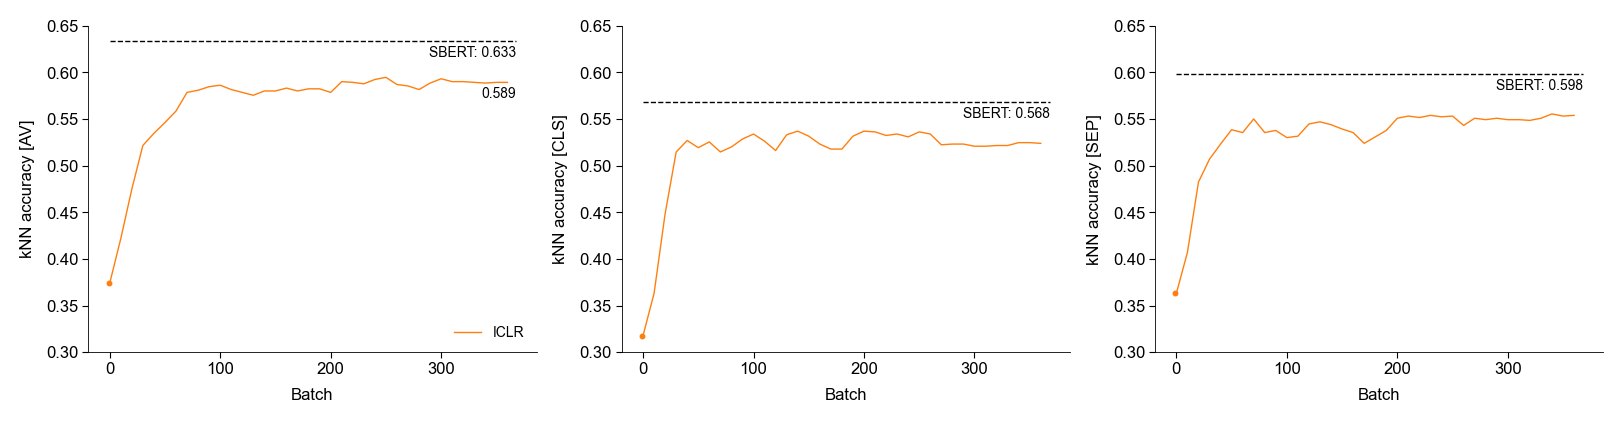

In [25]:
%matplotlib inline
n_epochs = 2

fig, ax = plt.subplots(1, 3, figsize=(8, 2), dpi=200)
# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

# losses_iclr = np.load(
#     variables_path
#     / saving_path
#     / "losses_batches_train_iclr_eval_iclr_v1.npy",
# )
knn_accuracies_iclr = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_eval_iclr_v1.npy",
)


ax[0].plot(
    np.arange(37) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0],
    label="ICLR",
    c="tab:orange",
)
ax[0].text(
    368,
    np.vstack(knn_accuracies_iclr)[:, 0][-1] - 0.005,
    f"{np.vstack(knn_accuracies_iclr)[:, 0][-1]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)
ax[0].hlines(knn_acc_highd_sbert[0], 0, 368, color="k", linestyles="--")
ax[0].text(
    368,
    knn_acc_highd_sbert[0] - 0.005,
    f"SBERT: {knn_acc_highd_sbert[0]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)
ax[0].legend(loc="lower right")
ax[0].scatter(-1, knn_acc_highd[0], c="tab:orange", s=5)
ax[0].set_ylim(0.3, 0.65)
ax[0].set_xlabel("Batch")
ax[0].set_ylabel("kNN accuracy [AV]")


ax[1].plot(
    np.arange(37) * 10,
    np.vstack(knn_accuracies_iclr)[:, 1],
    label="ICLR",
    c="tab:orange",
)
ax[1].hlines(knn_acc_highd_sbert[1], 0, 368, color="k", linestyles="--")
ax[1].text(
    368,
    knn_acc_highd_sbert[1] - 0.005,
    f"SBERT: {knn_acc_highd_sbert[1]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)
ax[1].scatter(-1, knn_acc_highd[1], c="tab:orange", s=5)
ax[1].set_ylim(0.3, 0.65)
ax[1].set_xlabel("Batch")
ax[1].set_ylabel("kNN accuracy [CLS]")


ax[2].plot(
    np.arange(37) * 10,
    np.vstack(knn_accuracies_iclr)[:, 2],
    label="ICLR",
    c="tab:orange",
)
ax[2].scatter(-1, knn_acc_highd[2], c="tab:orange", s=5)
ax[2].hlines(knn_acc_highd_sbert[2], 0, 368, color="k", linestyles="--")
ax[2].text(
    368,
    knn_acc_highd_sbert[2] - 0.005,
    f"SBERT: {knn_acc_highd_sbert[2]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)
ax[2].set_ylim(0.3, 0.65)
ax[2].set_xlabel("Batch")
ax[2].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path / "knn_accuracies_MPNet_batches_train_iclr_eval_iclr_v1.png"
)

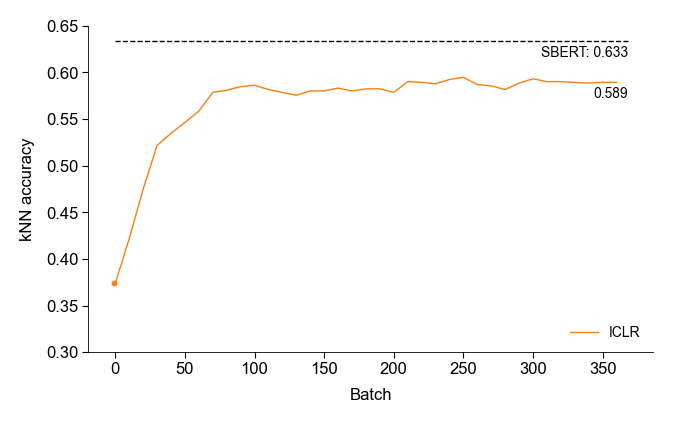

In [27]:
%matplotlib inline
n_epochs = 2

fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200)
# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

# losses_iclr = np.load(
#     variables_path
#     / saving_path
#     / "losses_batches_train_iclr_eval_iclr_v1.npy",
# )
knn_accuracies_iclr = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_eval_iclr_v1.npy",
)


ax.plot(
    np.arange(37) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0],
    label="ICLR",
    c="tab:orange",
)
ax.text(
    368,
    np.vstack(knn_accuracies_iclr)[:, 0][-1] - 0.005,
    f"{np.vstack(knn_accuracies_iclr)[:, 0][-1]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)
ax.hlines(knn_acc_highd_sbert[0], 0, 368, color="k", linestyles="--")
ax.text(
    368,
    knn_acc_highd_sbert[0] - 0.005,
    f"SBERT: {knn_acc_highd_sbert[0]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)
ax.legend(loc="lower right")
ax.scatter(-1, knn_acc_highd[0], c="tab:orange", s=5)
ax.set_ylim(0.3, 0.65)
ax.set_xlabel("Batch")
ax.set_ylabel("kNN accuracy")

fig.savefig(
    figures_path / "knn_accuracies_MPNet_batches_train_iclr_eval_iclr_v2.png"
)

## Optimize for CLS

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
%%time
i = 1
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("Training loader length: ", len(training_loader))

losses, knn_accuracies, _ = train_loop_batches_eval(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="cls",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(
    variables_path
    / saving_path
    / "losses_batches_train_iclr_cls_eval_iclr_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_cls_eval_iclr_v1",
    knn_accuracies,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Training loader length:  368


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

CPU times: user 1h 37min 17s, sys: 2h 8min 29s, total: 3h 45min 47s
Wall time: 2h 15min 56s


### Plot

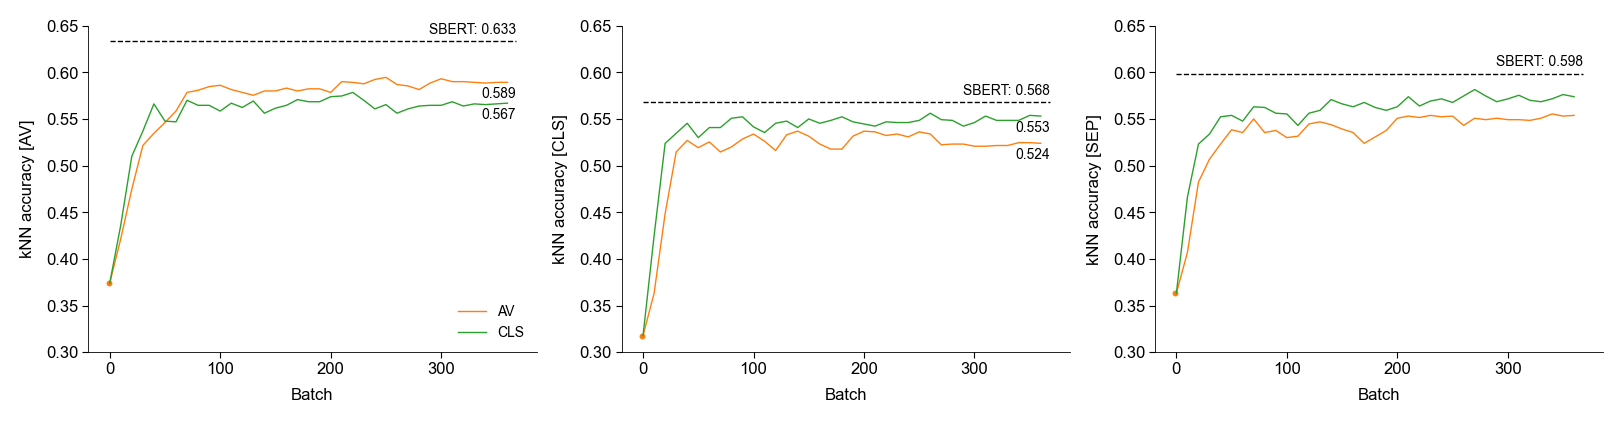

In [23]:
%matplotlib inline
n_epochs = 2
i = 1
model_name = model_names[i]

fig, ax = plt.subplots(1, 3, figsize=(8, 2), dpi=200)
# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
# (variables_path / saving_path).mkdir(exist_ok=True)

# losses_iclr = np.load(
#     variables_path
#     / saving_path
#     / "losses_batches_train_iclr_eval_iclr_v1.npy",
# )
knn_accuracies_iclr_av = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_eval_iclr_v1.npy",
)
knn_accuracies_iclr_cls = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_cls_eval_iclr_v1.npy",
)


ax[0].plot(
    np.arange(37) * 10,
    np.vstack(knn_accuracies_iclr_av)[:, 0],
    label="AV",
    c="tab:orange",
)
ax[0].text(
    368,
    np.vstack(knn_accuracies_iclr_av)[:, 0][-1] - 0.005,
    f"{np.vstack(knn_accuracies_iclr_av)[:, 0][-1]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)
ax[0].plot(
    np.arange(37) * 10,
    np.vstack(knn_accuracies_iclr_cls)[:, 0],
    label="CLS",
    c="tab:green",
)
ax[0].text(
    368,
    np.vstack(knn_accuracies_iclr_cls)[:, 0][-1] - 0.005,
    f"{np.vstack(knn_accuracies_iclr_cls)[:, 0][-1]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)
ax[0].hlines(knn_acc_highd_sbert[0], 0, 368, color="k", linestyles="--")
ax[0].text(
    368,
    knn_acc_highd_sbert[0] + 0.005,
    f"SBERT: {knn_acc_highd_sbert[0]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[0].legend(loc="lower right")
ax[0].scatter(-1, knn_acc_highd[0], c="tab:orange", s=5)
ax[0].set_ylim(0.3, 0.65)
ax[0].set_xlabel("Batch")
ax[0].set_ylabel("kNN accuracy [AV]")


ax[1].plot(
    np.arange(37) * 10,
    np.vstack(knn_accuracies_iclr_av)[:, 1],
    label="AV",
    c="tab:orange",
)
ax[1].text(
    368,
    np.vstack(knn_accuracies_iclr_av)[:, 1][-1] - 0.005,
    f"{np.vstack(knn_accuracies_iclr_av)[:, 1][-1]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)
ax[1].plot(
    np.arange(37) * 10,
    np.vstack(knn_accuracies_iclr_cls)[:, 1],
    label="CLS",
    c="tab:green",
)
ax[1].text(
    368,
    np.vstack(knn_accuracies_iclr_cls)[:, 1][-1] - 0.005,
    f"{np.vstack(knn_accuracies_iclr_cls)[:, 1][-1]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)
ax[1].hlines(knn_acc_highd_sbert[1], 0, 368, color="k", linestyles="--")
ax[1].text(
    368,
    knn_acc_highd_sbert[1] + 0.005,
    f"SBERT: {knn_acc_highd_sbert[1]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[1].scatter(-1, knn_acc_highd[1], c="tab:orange", s=5)
ax[1].set_ylim(0.3, 0.65)
ax[1].set_xlabel("Batch")
ax[1].set_ylabel("kNN accuracy [CLS]")


ax[2].plot(
    np.arange(37) * 10,
    np.vstack(knn_accuracies_iclr_av)[:, 2],
    label="AV",
    c="tab:orange",
)
ax[2].plot(
    np.arange(37) * 10,
    np.vstack(knn_accuracies_iclr_cls)[:, 2],
    label="CLS",
    c="tab:green",
)
ax[2].scatter(-1, knn_acc_highd[2], c="tab:orange", s=5)
ax[2].hlines(knn_acc_highd_sbert[2], 0, 368, color="k", linestyles="--")
ax[2].text(
    368,
    knn_acc_highd_sbert[2] + 0.005,
    f"SBERT: {knn_acc_highd_sbert[2]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[2].set_ylim(0.3, 0.65)
ax[2].set_xlabel("Batch")
ax[2].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / "knn_accuracies_MPNet_batches_train_iclr_cls_and_av_eval_iclr_v1.png"
)

### Sanity check final value knn accuracy

In [ ]:
# Training loader length:  368
todas = []
loader = np.arange(368)
for i_batch, elem in enumerate(loader):
    if (i_batch % 10 == 0) | (i_batch == len(loader) - 1):
        print(i_batch)
        todas.append(i_batch)
len(todas)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
367


38

#### Sanity check rerun

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [ ]:
%%time
i = 1
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("Training loader length: ", len(training_loader))

losses_2, knn_accuracies_2, _ = train_loop_batches_eval(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="cls",
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(
    variables_path
    / saving_path
    / "losses_batches_train_iclr_cls_eval_iclr_vsanitycheck",
    losses_2",
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_cls_eval_iclr_vsanitycheck",
    knn_accuracies_2,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Training loader length:  368


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

CPU times: user 1h 37min 17s, sys: 2h 8min 29s, total: 3h 45min 47s
Wall time: 2h 15min 56s


## Combined plot

In [17]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

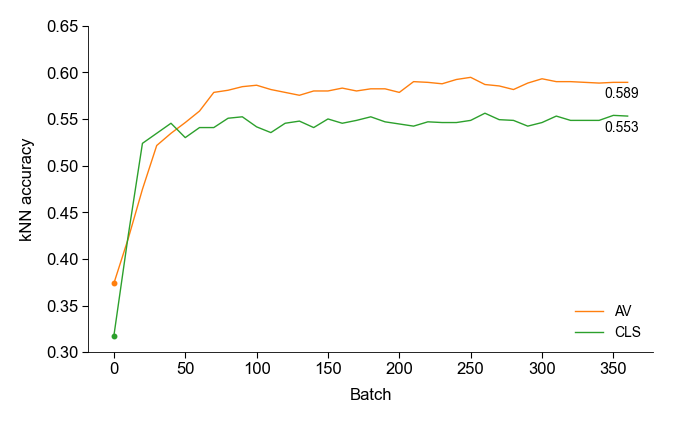

In [24]:
%matplotlib inline
n_epochs = 2
i = 1
model_name = model_names[i]

fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200)
# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
# (variables_path / saving_path).mkdir(exist_ok=True)

# losses_iclr = np.load(
#     variables_path
#     / saving_path
#     / "losses_batches_train_iclr_eval_iclr_v1.npy",
# )
knn_accuracies_iclr_av = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_eval_iclr_v1.npy",
)
knn_accuracies_iclr_cls = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_cls_eval_iclr_v1.npy",
)


ax.plot(
    np.arange(37) * 10,
    np.vstack(knn_accuracies_iclr_av)[:, 0],
    label="AV",
    c="tab:orange",
)
ax.text(
    368,
    np.vstack(knn_accuracies_iclr_av)[:, 0][-1] - 0.005,
    f"{np.vstack(knn_accuracies_iclr_av)[:, 0][-1]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)
ax.plot(
    np.arange(37) * 10,
    np.vstack(knn_accuracies_iclr_cls)[:, 1],
    label="CLS",
    c="tab:green",
)
ax.text(
    368,
    np.vstack(knn_accuracies_iclr_cls)[:, 1][-1] - 0.005,
    f"{np.vstack(knn_accuracies_iclr_cls)[:, 1][-1]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)
# ax.hlines(knn_acc_highd_sbert[0], 0, 368, color="k", linestyles="--")
# ax.text(
#     368,
#     knn_acc_highd_sbert[0] + 0.005,
#     f"SBERT: {knn_acc_highd_sbert[0]:.3f}",
#     fontsize=5,
#     va="bottom",
#     ha="right",
# )
ax.legend(loc="lower right")
ax.scatter(0, knn_acc_highd[0], c="tab:orange", s=5)
ax.scatter(0, knn_acc_highd[1], c="tab:green", s=5)
ax.set_ylim(0.3, 0.65)
ax.set_xlabel("Batch")
ax.set_ylabel("kNN accuracy")


fig.savefig(
    figures_path
    / "knn_accuracies_MPNet_batches_train_iclr_cls_and_av_eval_iclr_v2.png"
)

# Basic run

## Training run1
Optimize the [av] representation for 2 epochs for all models. batch_size=64, lr=2e-5.

Data augmentation (MultSentencesPairDataset), with n_cons_sntcs=2.

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model: ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])
    
    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="av",
        n_epochs=2,
        lr=2e-5,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower())/ Path(
    "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(variables_path / saving_path / "losses_run1", losses)
    np.save(
        variables_path / saving_path / "knn_accuracies_run1",
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  BERT
Running on device: cuda
bert-base-uncased


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SBERT
Running on device: cuda
sentence-transformers/all-mpnet-base-v2


  0%|          | 0/368 [00:00<?, ?it/s]

### Add new models

In [ ]:
model_names = [
    # "BERT",
    # "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    # "bert-base-uncased",
    # "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [22]:
model_names = [
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    # "SPECTER2",
]


model_paths = [
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-base",
    "johngiorgi/declutr-sci-base",
    # "allenai/specter2_base",
]

['SimCSE', 'DeCLUTR', 'DeCLUTR-sci']


In [21]:
%%time
for i, model_name in enumerate(model_names):
    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model: ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="av",
        n_epochs=2,
        lr=2e-5,
    )

    # save
    # parent_path = Path("embeddings_" + model_name.lower()).mkdir(exist_ok=True)
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(parents=True, exist_ok=True)

    np.save(variables_path / saving_path / "losses_run1", losses)
    np.save(
        variables_path / saving_path / "knn_accuracies_run1",
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  SimCSE
Running on device: cuda
princeton-nlp/unsup-simcse-bert-base-uncased


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  DeCLUTR
Running on device: cuda
johngiorgi/declutr-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  DeCLUTR-sci
Running on device: cuda
johngiorgi/declutr-sci-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SPECTER2
Running on device: cuda


OSError: allenai/specter2-base is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [24]:
%%time
# SPECTER 2
model_name = "SPECTER2"
model_path = "allenai/specter2_base"

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoAdapterModel.from_pretrained(model_path)
print(model_path)
# add adapter proximity
model.load_adapter(
    "allenai/specter2", source="hf", load_as="specter2", set_active=True
)


# # data
# training_dataset = MultOverlappingSentencesPairDataset(
#     iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
# )

# gen = torch.Generator()
# gen.manual_seed(seed)
# training_loader = torch.utils.data.DataLoader(
#     training_dataset, batch_size=64, shuffle=True, generator=gen
# )

# # training
# losses, knn_accuracies = train_loop(
#     model,
#     training_loader,
#     device,
#     iclr2024.abstract.to_list(),
#     tokenizer,
#     (labels_iclr != "unlabeled"),
#     labels_acc=labels_iclr[labels_iclr != "unlabeled"],
#     optimized_rep="av",
#     n_epochs=2,
#     lr=2e-5,
# )

# # save
# # parent_path = Path("embeddings_" + model_name.lower()).mkdir(exist_ok=True)
# saving_path = Path("embeddings_" + model_name.lower()) / Path(
#     "updated_dataset"
# )
# (variables_path / saving_path).mkdir(parents=True, exist_ok=True)

# np.save(variables_path / saving_path / "losses_run1", losses)
# np.save(
#     variables_path / saving_path / "knn_accuracies_run1",
#     knn_accuracies,
# )

# # clean up
# model = None
# tokenizer = None
# gc.collect()
# torch.cuda.empty_cache()

# print("----------------------------")

Model:  SPECTER2
Running on device: cuda


allenai/specter2_base


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 3.19 s, sys: 838 ms, total: 4.03 s
Wall time: 5.08 s


'specter2'

In [26]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

bert.embeddings.word_embeddings.weight: True
bert.embeddings.position_embeddings.weight: True
bert.embeddings.token_type_embeddings.weight: True
bert.embeddings.LayerNorm.weight: True
bert.embeddings.LayerNorm.bias: True
bert.encoder.layer.0.attention.self.query.weight: True
bert.encoder.layer.0.attention.self.query.bias: True
bert.encoder.layer.0.attention.self.key.weight: True
bert.encoder.layer.0.attention.self.key.bias: True
bert.encoder.layer.0.attention.self.value.weight: True
bert.encoder.layer.0.attention.self.value.bias: True
bert.encoder.layer.0.attention.output.dense.weight: True
bert.encoder.layer.0.attention.output.dense.bias: True
bert.encoder.layer.0.attention.output.LayerNorm.weight: True
bert.encoder.layer.0.attention.output.LayerNorm.bias: True
bert.encoder.layer.0.intermediate.dense.weight: True
bert.encoder.layer.0.intermediate.dense.bias: True
bert.encoder.layer.0.output.dense.weight: True
bert.encoder.layer.0.output.dense.bias: True
bert.encoder.layer.0.output.Lay

In [27]:
%%time
# SPECTER 2
model_name = "SPECTER2"
model_path = "allenai/specter2_base"

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoAdapterModel.from_pretrained(model_path)
print(model_path)
# add adapter proximity
model.load_adapter(
    "allenai/specter2", source="hf", load_as="specter2", set_active=True
)


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=2,
    lr=2e-5,
)

# save
# parent_path = Path("embeddings_" + model_name.lower()).mkdir(exist_ok=True)
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1",
    knn_accuracies,
)

# clean up
model = None
tokenizer = None
gc.collect()
torch.cuda.empty_cache()

print("----------------------------")

Model:  SPECTER2
Running on device: cuda


allenai/specter2_base


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 9min 1s, sys: 13min 13s, total: 22min 15s
Wall time: 17min 43s


### Plot

/tmp/ipykernel_77837/66919400.py:40: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0, 1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)
/tmp/ipykernel_77837/66919400.py:61: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1, 0].scatter(-0.4, knn_acc_highd[1], c=color, s=5)
/tmp/ipykernel_77837/66919400.py:74: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapp

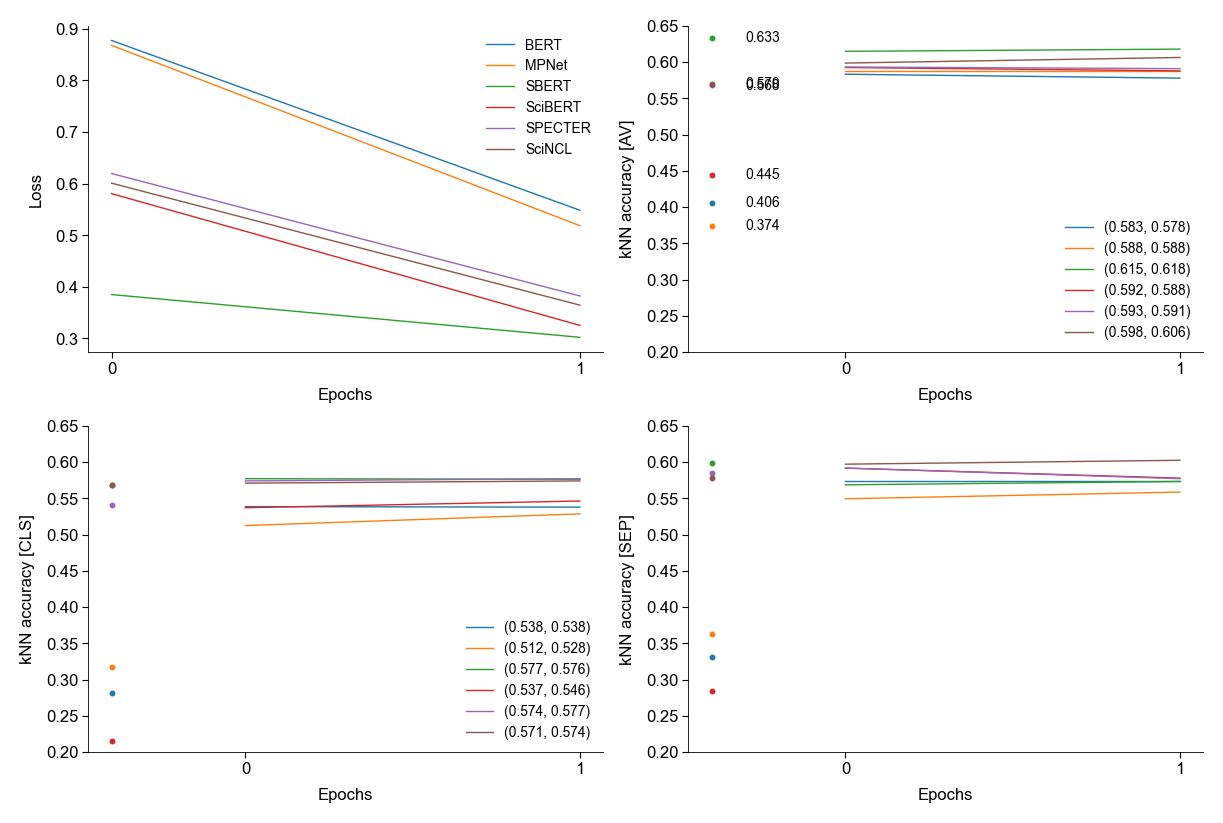

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 2
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run1.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run1.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

    color = colormap(i)

    axs[0, 0].plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs[0, 0].set_xticks(np.arange(n_epochs))
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    axs[0, 1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 0],
        label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
        color=color,
    )
    axs[0, 1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)
    axs[0, 1].text(
        -0.3,
        knn_acc_highd[0],
        f"{knn_acc_highd[0]:.3f}",
        fontsize=5,
        va="center",
        ha="left",
    )
    axs[0, 1].set_xticks(np.arange(n_epochs))
    axs[0, 1].set_ylim(0.2, 0.65)
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylabel("kNN accuracy [AV]")
    axs[0, 1].legend(loc="lower right")

    axs[1, 0].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 1],
        label=f"({knn_accuracies[0, 1]:.3f}, {knn_accuracies[-1, 1]:.3f})",
        color=color,
    )
    axs[1, 0].scatter(-0.4, knn_acc_highd[1], c=color, s=5)
    axs[1, 0].set_xticks(np.arange(n_epochs))
    axs[1, 0].set_ylim(0.2, 0.65)
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("kNN accuracy [CLS]")
    axs[1, 0].legend()

    axs[1, 1].plot(
        np.arange(n_epochs),
        knn_accuracies[:, 2],
        label=model_name,
        color=color,
    )
    axs[1, 1].scatter(-0.4, knn_acc_highd[2], c=color, s=5)
    axs[1, 1].set_xticks(np.arange(n_epochs))
    axs[1, 1].set_ylim(0.2, 0.65)
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(figures_path / "loss_and_knn_accuracy_training_run1_v1.png")

### Fancier plots

In [22]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]


model_paths = [
    # "bert-base-uncased",
    # "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
    # "princeton-nlp/unsup-simcse-bert-base-uncased",
    # "johngiorgi/declutr-base",
    # "johngiorgi/declutr-sci-base",
    # "allenai/specter2_base",
]

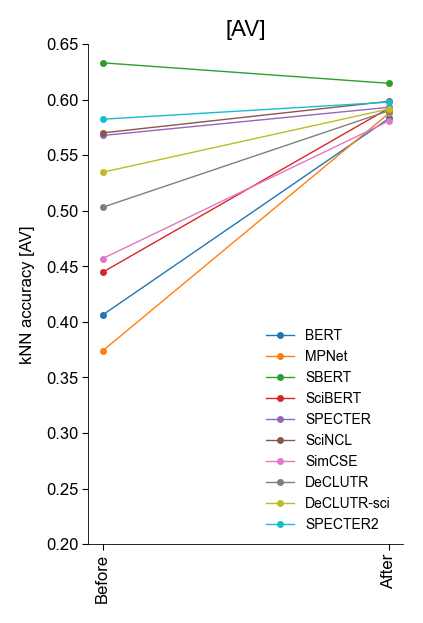

In [28]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2, 3), dpi=200)

colormap = plt.get_cmap("tab10")
rep = 0  # av

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run1.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run1.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    color = colormap(i)

    ax.plot(
        np.arange(2),
        np.array([knn_accuracies_before[rep], knn_accuracies_after[0, rep]]),
        label=f"{model_name}",  #: ({knn_accuracies_before[rep]:.3f}, {knn_accuracies_after[-1, rep]:.3f})",
        color=color,
        marker=".",
        ms=3,
    )
    # ax.text(
    #     0,
    #     knn_accuracies_before[1],
    #     f"{knn_accuracies_before[1]:.3f}",
    #     fontsize=5,
    #     va="center",
    #     ha="right",
    # )
    # ax.text(
    #     1,
    #     knn_accuracies_after[-1, 1],
    #     f"{knn_accuracies_after[-1, 1]:.3f}",
    #     fontsize=5,
    #     va="center",
    #     ha="left",
    # )
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels(["Before", "After"], rotation="vertical")
    ax.set_ylim(0.2, 0.65)
    ax.set_ylabel("kNN accuracy [AV]")
    ax.legend(loc="lower right")
    ax.set_title("[AV]")


fig.savefig(figures_path / "loss_and_knn_accuracy_training_run1_fancy1_v2.png")

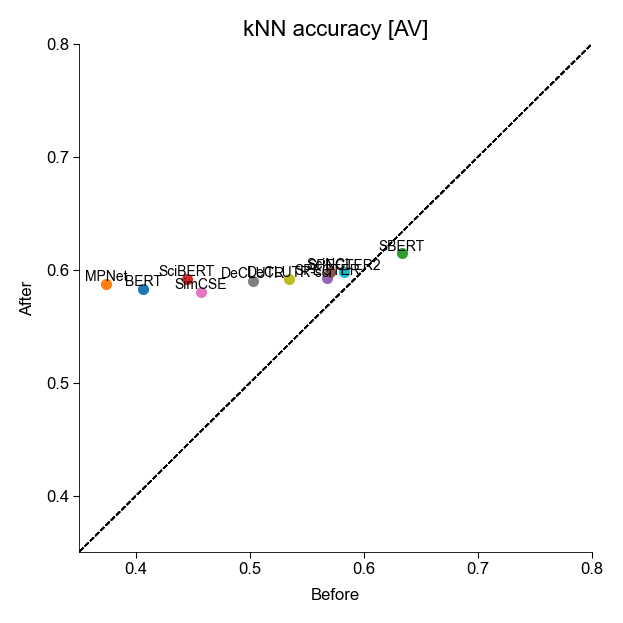

In [29]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

colormap = plt.get_cmap("tab10")
rep = 0  # av

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run1.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run1.npy"
    )
    # print(knn_accuracies_after.shape)

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    color = colormap(i)

    ax.plot([0, 1], [0, 1], color="k", linestyle="--")
    ax.scatter(
        knn_accuracies_before[rep],
        knn_accuracies_after[0, rep],
        # label=f"{model_name}",  #: ({knn_accuracies_before[rep]:.3f}, {knn_accuracies_after[-1, rep]:.3f})",
        color=color,
    )
    ax.text(
        knn_accuracies_before[rep],
        knn_accuracies_after[0, rep],
        f"{model_name}",
        fontsize=5,
        va="bottom",
        ha="center",
    )

    # ax.set_xticks(np.arange(2))
    # ax.set_xticklabels(["Before", "After"], rotation="vertical")
    ax.set_xlim(0.35, 0.8)
    ax.set_ylim(0.35, 0.8)
    ax.set_xlabel("Before")
    ax.set_ylabel("After")
    # ax.legend(loc="lower right")
    ax.set_title("kNN accuracy [AV]")
    # ax.axis("equal")


# fig.savefig(figures_path / "loss_and_knn_accuracy_training_run1_fancy2_v2.png")

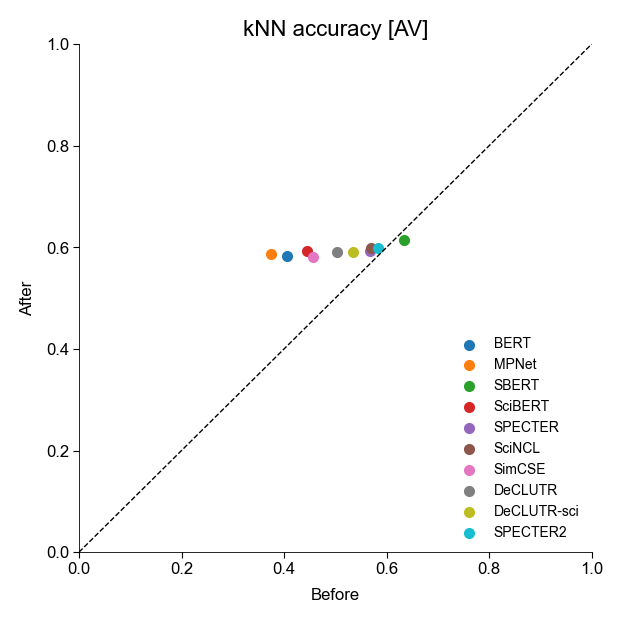

In [30]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

colormap = plt.get_cmap("tab10")
rep = 0  # av

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run1.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run1.npy"
    )
    # print(knn_accuracies_after.shape)

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    color = colormap(i)
    if i == 0:
        ax.plot([0, 1], [0, 1], color="k", linestyle="--")
    ax.scatter(
        knn_accuracies_before[rep],
        knn_accuracies_after[0, rep],
        label=f"{model_name}",
        color=color,
    )
    # ax.text(
    #     knn_accuracies_before[rep],
    #     knn_accuracies_after[-1, rep],
    #     f"{model_name}",
    #     fontsize=5,
    #     va="bottom",
    #     ha="center",
    # )

    # ax.set_xticks(np.arange(2))
    # ax.set_xticklabels(["Before", "After"], rotation="vertical")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Before")
    ax.set_ylabel("After")
    ax.legend(loc="lower right")
    ax.set_title("kNN accuracy [AV]")
    # ax.axis("equal")


fig.savefig(figures_path / "loss_and_knn_accuracy_training_run1_fancy2_v3.png")

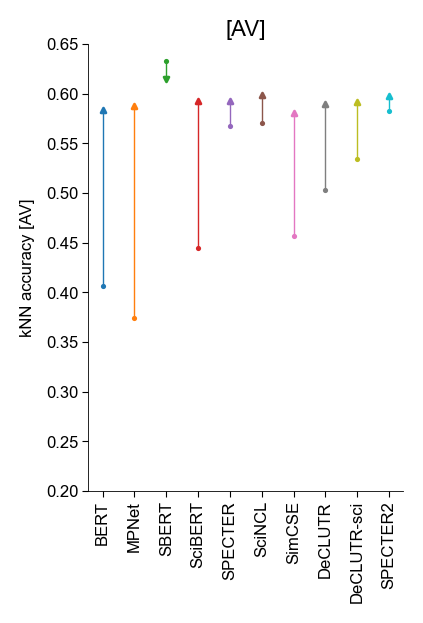

In [45]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2, 3), dpi=200)

colormap = plt.get_cmap("tab10")
rep = 0  # av

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run1.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run1.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    color = colormap(i)

    ax.plot(
        np.ones(2) * i,
        np.array([knn_accuracies_before[rep], knn_accuracies_after[0, rep]]),
        label=f"{model_name}",
        color=color,
        # marker=".",
        # ms=3,
    )
    ax.scatter(
        i,
        knn_accuracies_before[rep],
        color=color,
        marker=".",
        s=3,
    )
    if knn_accuracies_before[rep] <= knn_accuracies_after[0, rep]:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="^",
            s=3,
        )
    else:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="v",
            s=3,
        )

    ax.set_xticks(np.arange(len(model_names)))
    ax.set_xticklabels(model_names, rotation="vertical")
    ax.set_ylim(0.2, 0.65)
    ax.set_ylabel("kNN accuracy [AV]")
    # ax.legend(loc="lower right")
    ax.set_title("[AV]")


fig.savefig(figures_path / "loss_and_knn_accuracy_training_run1_fancy3_v1.png")

In [10]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]

In [11]:
colormap = plt.get_cmap("tab10")
dict_original_colors = dict()
for i, model_name in enumerate(model_names):
    color = colormap(i)
    dict_original_colors[model_name] = colormap(i)

In [12]:
# new order
model_names = [
    "MPNet",
    "BERT",
    "SciBERT",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SciNCL",
    "SPECTER",
    "SPECTER2",
    "SBERT",
]

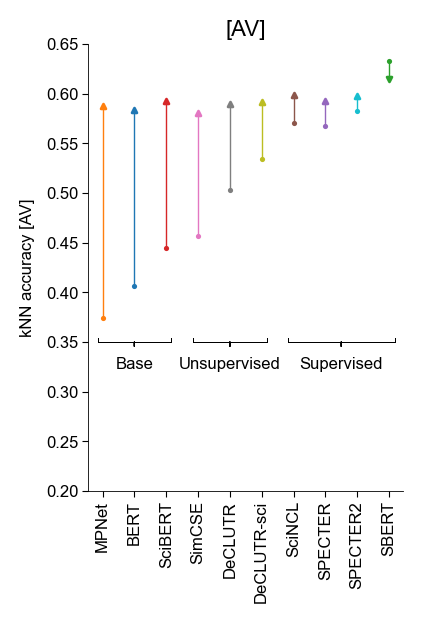

In [14]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2, 3), dpi=200)

rep = 0  # av

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run1.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run1.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    color = dict_original_colors[model_name]

    ax.plot(
        np.ones(2) * i,
        np.array([knn_accuracies_before[rep], knn_accuracies_after[0, rep]]),
        label=f"{model_name}",
        color=color,
        # marker=".",
        # ms=3,
    )
    ax.scatter(
        i,
        knn_accuracies_before[rep],
        color=color,
        marker=".",
        s=3,
    )
    if knn_accuracies_before[rep] <= knn_accuracies_after[0, rep]:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="^",
            s=3,
        )
    else:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="v",
            s=3,
        )

    ax.set_xticks(np.arange(len(model_names)))
    ax.set_xticklabels(model_names, rotation="vertical")
    ax.set_ylim(0.2, 0.65)
    ax.set_ylabel("kNN accuracy [AV]")
    # ax.legend(loc="lower right")
    ax.set_title("[AV]")
    ax.annotate(
        "Base",
        xy=(1, 0.35),
        xytext=(1, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=2.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )

    ax.annotate(
        "Unsupervised",
        xy=(4, 0.35),
        xytext=(4, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=2.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )

    ax.annotate(
        "Supervised",
        xy=(7.5, 0.35),
        xytext=(7.5, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=3.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )


fig.savefig(figures_path / "loss_and_knn_accuracy_training_run1_fancy3_v3.png")

### Rerun for embeddings

In [170]:
model_names = [
    # "BERT",
    "MPNet",
    #     "SBERT",
    #     "SciBERT",
    #     "SPECTER",
    #     "SciNCL",
]


model_paths = [
    # "bert-base-uncased",
    "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [171]:
%%time
for i, model_name in enumerate(model_names):
    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model: ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    (
        losses,
        knn_accuracies,
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="av",
        n_epochs=1,
        lr=2e-5,
        return_embeddings=True,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(
        variables_path
        / saving_path
        / "embedding_asbtracts_only_cls_after_training_av_1_epoch",
        embedding_cls,
    )
    np.save(
        variables_path
        / saving_path
        / "embedding_asbtracts_only_sep_after_training_av_1_epoch",
        embedding_sep,
    )
    np.save(
        variables_path
        / saving_path
        / "embedding_asbtracts_only_av_after_training_av_1_epoch",
        embedding_av,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 9min 20s, sys: 7min 49s, total: 17min 9s
Wall time: 9min 4s


In [182]:
model_name

'MPNet'

In [180]:
%%time
# t-SNE
# load

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

embedding_av = np.load(
    variables_path
    / saving_path
    / "embedding_asbtracts_only_av_after_training_av_1_epoch.npy",  # embedding_asbtracts_only_av_after_training_av_1_epoch
)

tsne_av = run_tsne_simple(embedding_av)

np.save(
    variables_path
    / saving_path
    / "tsne_abstracts_only_av_after_training_av_1_epoch",
    tsne_av,
)

/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


CPU times: user 2min 6s, sys: 21.5 s, total: 2min 27s
Wall time: 1min 5s


## Training run3
Optimize the [cls] representation for 2 epochs for all models. batch_size=64, lr=2e-5.

Data augmentation (MultSentencesPairDataset), with n_cons_sntcs=2.

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model: ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="cls",
        n_epochs=2,
        lr=2e-5,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(variables_path / saving_path / "losses_run3", losses)
    np.save(
        variables_path / saving_path / "knn_accuracies_run3",
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  BERT
Running on device: cuda
bert-base-uncased


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SBERT
Running on device: cuda
sentence-transformers/all-mpnet-base-v2


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SciBERT
Running on device: cuda
allenai/scibert_scivocab_uncased


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SPECTER
Running on device: cuda
allenai/specter


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SciNCL
Running on device: cuda
malteos/scincl


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 1h 4min 25s, sys: 1h 26min 14s, total: 2h 30min 40s
Wall time: 1h 41min 55s


### Add new models

In [28]:
model_names = [
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]


model_paths = [
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-base",
    "johngiorgi/declutr-sci-base",
    "allenai/specter2_base",
]

In [29]:
%%time
for i, model_name in enumerate(model_names):
    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model: ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    if model_name == "SPECTER2":
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoAdapterModel.from_pretrained(model_paths[i])
        print(model_paths[i])
        # add adapter proximity
        model.load_adapter(
            "allenai/specter2",
            source="hf",
            load_as="specter2",
            set_active=True,
        )

    else:
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoModel.from_pretrained(model_paths[i])
        print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="cls",
        n_epochs=2,
        lr=2e-5,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(variables_path / saving_path / "losses_run3", losses)
    np.save(
        variables_path / saving_path / "knn_accuracies_run3",
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  SimCSE
Running on device: cuda
princeton-nlp/unsup-simcse-bert-base-uncased


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  DeCLUTR
Running on device: cuda
johngiorgi/declutr-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  DeCLUTR-sci
Running on device: cuda
johngiorgi/declutr-sci-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SPECTER2
Running on device: cuda
allenai/specter2_base


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 33min 17s, sys: 53min 56s, total: 1h 27min 13s
Wall time: 1h 7min 42s


### Plot

/tmp/ipykernel_77837/2658889698.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0, 1].scatter(0.4, knn_acc_highd[0], c=color, s=5)
/tmp/ipykernel_77837/2658889698.py:73: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1, 0].scatter(0.4, knn_acc_highd[1], c=color, s=5)
/tmp/ipykernel_77837/2658889698.py:87: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-

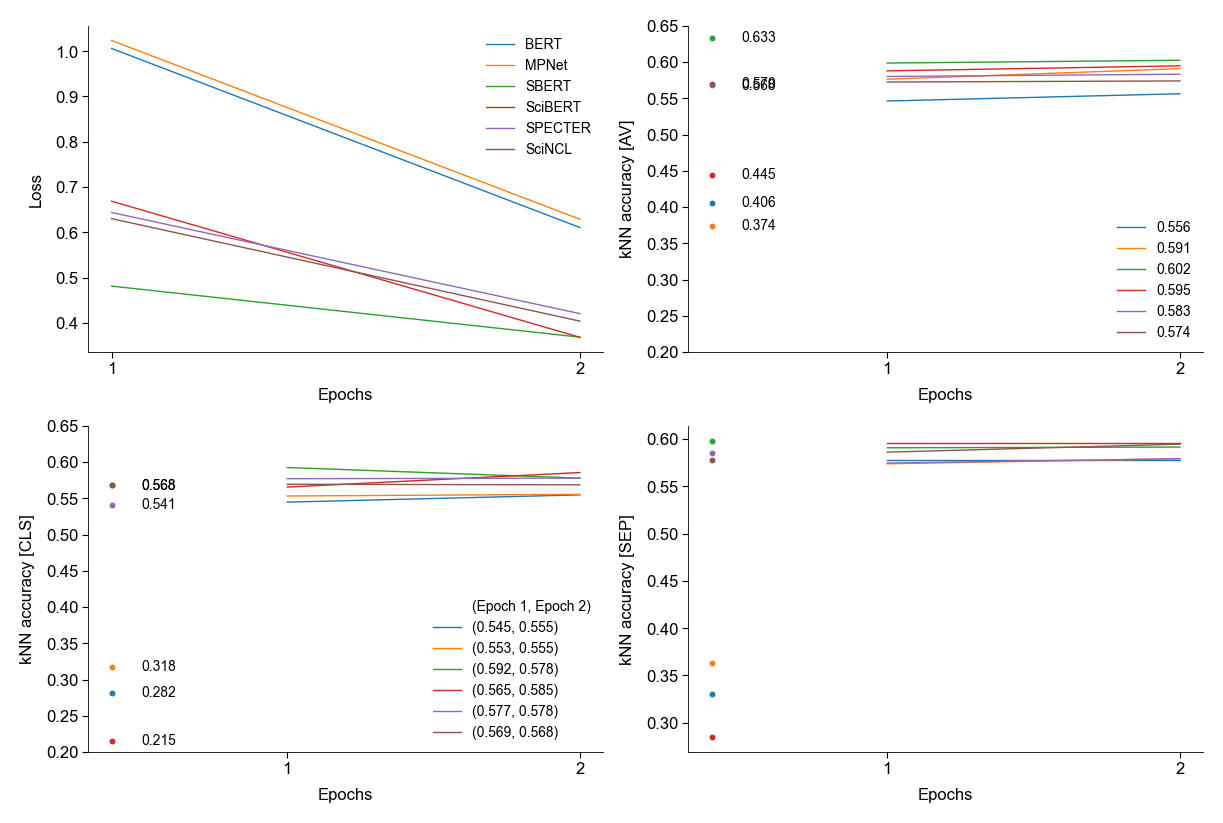

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 2
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run3.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run3.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

    color = colormap(i)
    # losses
    axs[0, 0].plot(
        np.arange(n_epochs) + 1,
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs[0, 0].set_xticks(np.arange(n_epochs) + 1)
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    # AV
    axs[0, 1].plot(
        np.arange(n_epochs) + 1,
        knn_accuracies[:, 0],
        label=f"{knn_accuracies[-1, 0]:.3f}",
        color=color,
    )
    axs[0, 1].scatter(0.4, knn_acc_highd[0], c=color, s=5)
    axs[0, 1].text(
        0.5,
        knn_acc_highd[0],
        f"{knn_acc_highd[0]:.3f}",
        fontsize=5,
        va="center",
        ha="left",
    )
    axs[0, 1].set_xticks(np.arange(n_epochs) + 1)
    axs[0, 1].set_ylim(0.2, 0.65)
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylabel("kNN accuracy [AV]")
    axs[0, 1].legend(loc="lower right")

    # CLS
    if i == 0:
        axs[1, 0].plot([], [], c="white", label="(Epoch 1, Epoch 2)")
    axs[1, 0].plot(
        np.arange(n_epochs) + 1,
        knn_accuracies[:, 1],
        label=f"({knn_accuracies[0, 1]:.3f}, {knn_accuracies[-1, 1]:.3f})",
        color=color,
    )
    axs[1, 0].text(
        0.5,
        knn_acc_highd[1],
        f"{knn_acc_highd[1]:.3f}",
        fontsize=5,
        va="center",
        ha="left",
    )
    axs[1, 0].scatter(0.4, knn_acc_highd[1], c=color, s=5)
    axs[1, 0].set_xticks(np.arange(n_epochs) + 1)
    axs[1, 0].set_ylim(0.2, 0.65)
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("kNN accuracy [CLS]")
    axs[1, 0].legend(loc="lower right")

    # SEP
    axs[1, 1].plot(
        np.arange(n_epochs) + 1,
        knn_accuracies[:, 2],
        label=model_name,
        color=color,
    )
    axs[1, 1].scatter(0.4, knn_acc_highd[2], c=color, s=5)
    axs[1, 1].set_xticks(np.arange(n_epochs) + 1)
    # axs[1, 1].set_ylim(0.2, 0.65)
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(figures_path / "loss_and_knn_accuracy_training_run3_v1.png")

/tmp/ipykernel_208480/2722917780.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0, 1].scatter(0.4, knn_acc_highd[0], c=color, s=5)
/tmp/ipykernel_208480/2722917780.py:73: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1, 0].scatter(0.4, knn_acc_highd[1], c=color, s=5)
/tmp/ipykernel_208480/2722917780.py:87: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as val

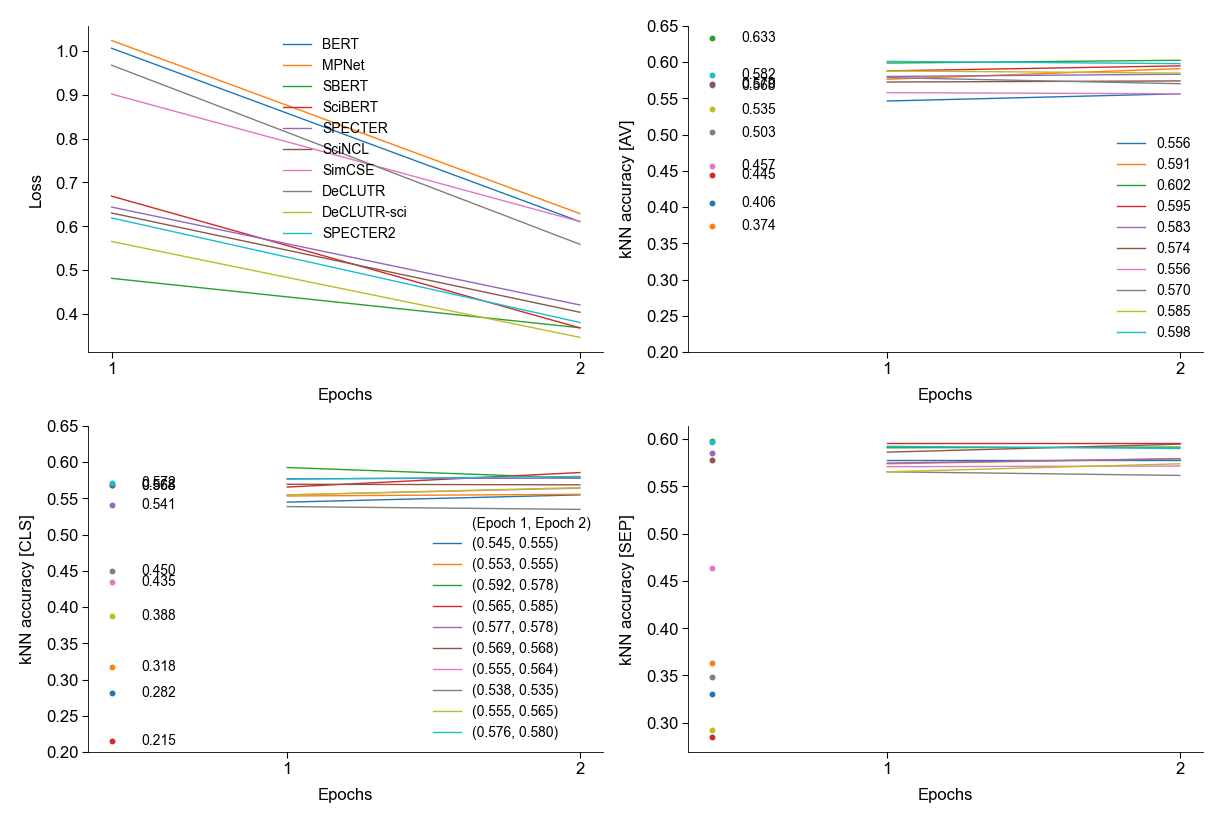

In [25]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 2
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run3.npy")
    knn_accuracies = np.load(
        variables_path / saving_path / "knn_accuracies_run3.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

    color = colormap(i)
    # losses
    axs[0, 0].plot(
        np.arange(n_epochs) + 1,
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs[0, 0].set_xticks(np.arange(n_epochs) + 1)
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    # AV
    axs[0, 1].plot(
        np.arange(n_epochs) + 1,
        knn_accuracies[:, 0],
        label=f"{knn_accuracies[-1, 0]:.3f}",
        color=color,
    )
    axs[0, 1].scatter(0.4, knn_acc_highd[0], c=color, s=5)
    axs[0, 1].text(
        0.5,
        knn_acc_highd[0],
        f"{knn_acc_highd[0]:.3f}",
        fontsize=5,
        va="center",
        ha="left",
    )
    axs[0, 1].set_xticks(np.arange(n_epochs) + 1)
    axs[0, 1].set_ylim(0.2, 0.65)
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylabel("kNN accuracy [AV]")
    axs[0, 1].legend(loc="lower right")

    # CLS
    if i == 0:
        axs[1, 0].plot([], [], c="white", label="(Epoch 1, Epoch 2)")
    axs[1, 0].plot(
        np.arange(n_epochs) + 1,
        knn_accuracies[:, 1],
        label=f"({knn_accuracies[0, 1]:.3f}, {knn_accuracies[-1, 1]:.3f})",
        color=color,
    )
    axs[1, 0].text(
        0.5,
        knn_acc_highd[1],
        f"{knn_acc_highd[1]:.3f}",
        fontsize=5,
        va="center",
        ha="left",
    )
    axs[1, 0].scatter(0.4, knn_acc_highd[1], c=color, s=5)
    axs[1, 0].set_xticks(np.arange(n_epochs) + 1)
    axs[1, 0].set_ylim(0.2, 0.65)
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("kNN accuracy [CLS]")
    axs[1, 0].legend(loc="lower right")

    # SEP
    axs[1, 1].plot(
        np.arange(n_epochs) + 1,
        knn_accuracies[:, 2],
        label=model_name,
        color=color,
    )
    axs[1, 1].scatter(0.4, knn_acc_highd[2], c=color, s=5)
    axs[1, 1].set_xticks(np.arange(n_epochs) + 1)
    # axs[1, 1].set_ylim(0.2, 0.65)
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(figures_path / "loss_and_knn_accuracy_training_run3_v2.png")

### Fancier plots

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]


model_paths = [
    # "bert-base-uncased",
    # "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
    # "princeton-nlp/unsup-simcse-bert-base-uncased",
    # "johngiorgi/declutr-base",
    # "johngiorgi/declutr-sci-base",
    # "allenai/specter2_base",
]

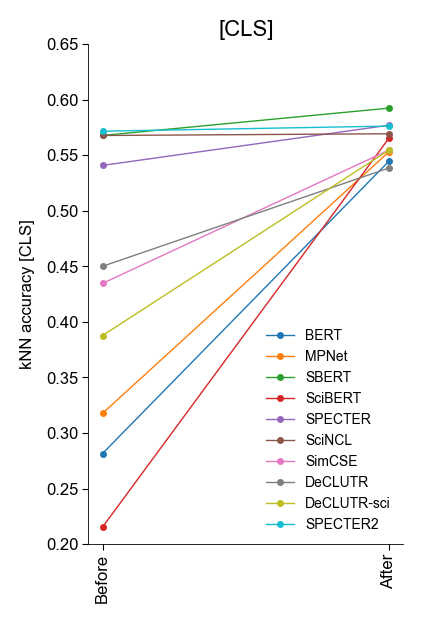

In [27]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2, 3), dpi=200)

colormap = plt.get_cmap("tab10")
rep = 1

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run3.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run3.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    color = colormap(i)

    ax.plot(
        np.arange(2),
        np.array([knn_accuracies_before[rep], knn_accuracies_after[0, rep]]),
        label=f"{model_name}",  #: ({knn_accuracies_before[rep]:.3f}, {knn_accuracies_after[-1, rep]:.3f})",
        color=color,
        marker=".",
        ms=3,
    )
    # ax.text(
    #     0,
    #     knn_accuracies_before[1],
    #     f"{knn_accuracies_before[1]:.3f}",
    #     fontsize=5,
    #     va="center",
    #     ha="right",
    # )
    # ax.text(
    #     1,
    #     knn_accuracies_after[-1, 1],
    #     f"{knn_accuracies_after[-1, 1]:.3f}",
    #     fontsize=5,
    #     va="center",
    #     ha="left",
    # )
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels(["Before", "After"], rotation="vertical")
    ax.set_ylim(0.2, 0.65)
    ax.set_ylabel("kNN accuracy [CLS]")
    ax.legend(loc="lower right")
    ax.set_title("[CLS]")


fig.savefig(figures_path / "loss_and_knn_accuracy_training_run3_fancy1_v2.png")

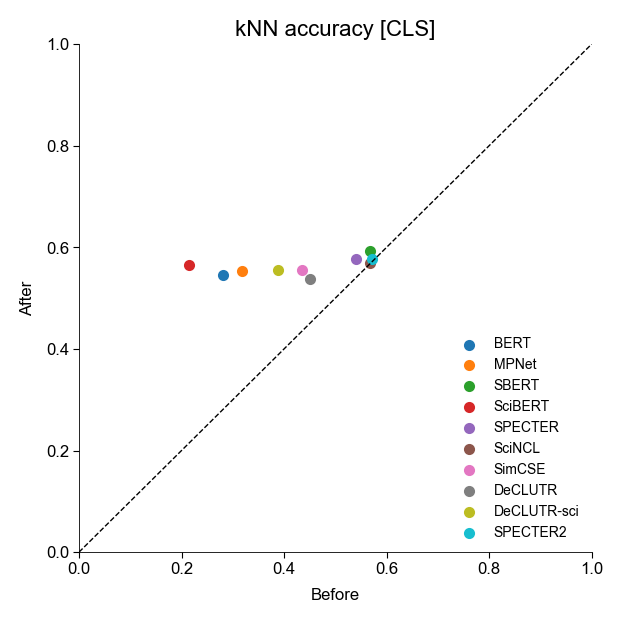

In [31]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

colormap = plt.get_cmap("tab10")
rep = 1

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run3.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run3.npy"
    )
    # print(knn_accuracies_after.shape)

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    color = colormap(i)
    if i == 0:
        ax.plot([0, 1], [0, 1], color="k", linestyle="--")
    ax.scatter(
        knn_accuracies_before[rep],
        knn_accuracies_after[0, rep],
        label=f"{model_name}",  #: ({knn_accuracies_before[rep]:.3f}, {knn_accuracies_after[-1, rep]:.3f})",
        color=color,
    )
    # ax.text(
    #     knn_accuracies_before[rep],
    #     knn_accuracies_after[-1, rep],
    #     f"{model_name}",
    #     fontsize=5,
    #     va="bottom",
    #     ha="center",
    # )

    # ax.set_xticks(np.arange(2))
    # ax.set_xticklabels(["Before", "After"], rotation="vertical")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Before")
    ax.set_ylabel("After")
    ax.legend(loc="lower right")
    ax.set_title("kNN accuracy [CLS]")
    # ax.axis("equal")


fig.savefig(figures_path / "loss_and_knn_accuracy_training_run3_fancy2_v3.png")

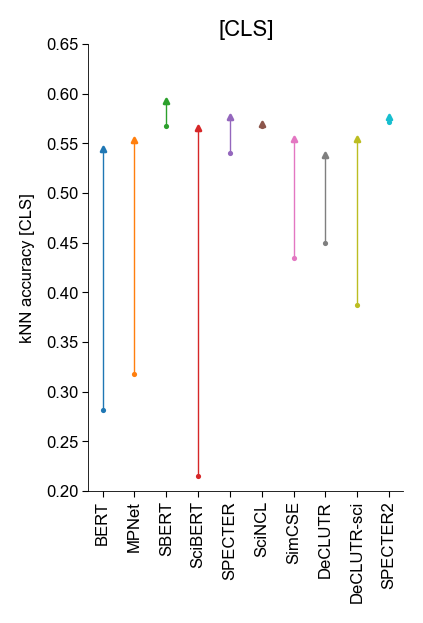

In [46]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2, 3), dpi=200)

colormap = plt.get_cmap("tab10")
rep = 1

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run3.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run3.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    color = colormap(i)

    ax.plot(
        np.ones(2) * i,
        np.array([knn_accuracies_before[rep], knn_accuracies_after[0, rep]]),
        label=f"{model_name}",
        color=color,
        # marker=".",
        # ms=3,
    )
    ax.scatter(
        i,
        knn_accuracies_before[rep],
        color=color,
        marker=".",
        s=3,
    )
    if knn_accuracies_before[rep] <= knn_accuracies_after[0, rep]:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="^",
            s=3,
        )
    else:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="v",
            s=3,
        )

    ax.set_xticks(np.arange(len(model_names)))
    ax.set_xticklabels(model_names, rotation="vertical")
    ax.set_ylim(0.2, 0.65)
    ax.set_ylabel("kNN accuracy [CLS]")
    # ax.legend(loc="lower right")
    ax.set_title("[CLS]")


fig.savefig(figures_path / "loss_and_knn_accuracy_training_run3_fancy3_v1.png")

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]

In [ ]:
colormap = plt.get_cmap("tab10")
dict_original_colors = dict()
for i, model_name in enumerate(model_names):
    color = colormap(i)
    dict_original_colors[model_name] = colormap(i)

In [ ]:
# new order
model_names = [
    "MPNet",
    "BERT",
    "SciBERT",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SciNCL",
    "SPECTER",
    "SPECTER2",
    "SBERT",
]

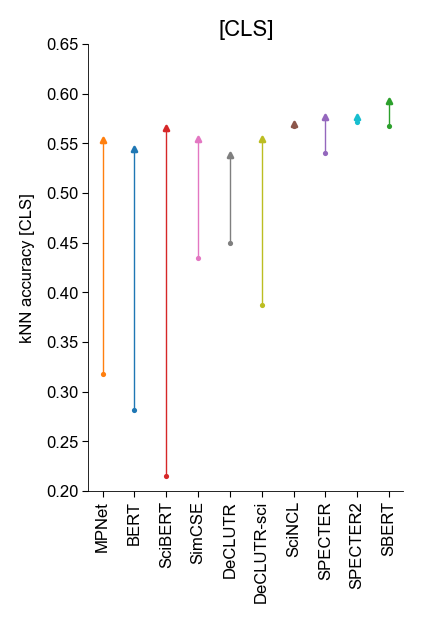

In [15]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2, 3), dpi=200)
rep = 1

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run3.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run3.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    color = dict_original_colors[model_name]

    ax.plot(
        np.ones(2) * i,
        np.array([knn_accuracies_before[rep], knn_accuracies_after[0, rep]]),
        label=f"{model_name}",
        color=color,
        # marker=".",
        # ms=3,
    )
    ax.scatter(
        i,
        knn_accuracies_before[rep],
        color=color,
        marker=".",
        s=3,
    )
    if knn_accuracies_before[rep] <= knn_accuracies_after[0, rep]:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="^",
            s=3,
        )
    else:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="v",
            s=3,
        )

    ax.set_xticks(np.arange(len(model_names)))
    ax.set_xticklabels(model_names, rotation="vertical")
    ax.set_ylim(0.2, 0.65)
    ax.set_ylabel("kNN accuracy [CLS]")
    # ax.legend(loc="lower right")
    ax.set_title("[CLS]")
    # ax.annotate(
    #     "Base",
    #     xy=(1, 0.35),
    #     xytext=(1, 0.32),
    #     xycoords="data",
    #     fontsize=6,
    #     ha="center",
    #     va="bottom",
    #     bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
    #     arrowprops=dict(
    #         arrowstyle="-[, widthB=2.2, lengthB=0.25", lw=0.35, color="k"
    #     ),
    # )


fig.savefig(figures_path / "loss_and_knn_accuracy_training_run3_fancy3_v3.png")

### Combined AV and CLS plot

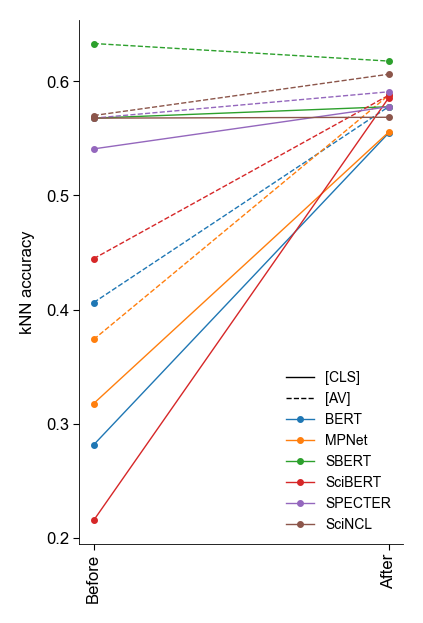

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2, 3), dpi=200)

colormap = plt.get_cmap("tab10")
# rep = 1

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    # losses = np.load(variables_path / saving_path / "losses_run3.npy")
    knn_accuracies_av_after = np.load(
        variables_path / saving_path / "knn_accuracies_run1.npy"
    )
    knn_accuracies_cls_after = np.load(
        variables_path / saving_path / "knn_accuracies_run3.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    color = colormap(i)
    if i == 0:
        ax.plot([], [], c="k", linestyle="-", label="[CLS]")
        ax.plot([], [], c="k", linestyle="--", label="[AV]")

    ax.plot(
        np.arange(2),
        np.array([knn_accuracies_before[0], knn_accuracies_av_after[-1, 0]]),
        # label=f"{model_name}",
        color=color,
        linestyle="--",
        marker=".",
        ms=3,
    )
    ax.plot(
        np.arange(2),
        np.array([knn_accuracies_before[1], knn_accuracies_cls_after[-1, 1]]),
        label=f"{model_name}",  #: ({knn_accuracies_before[rep]:.3f}, {knn_accuracies_after[-1, rep]:.3f})",
        color=color,
        marker=".",
        ms=3,
    )

    # ax.text(
    #     0,
    #     knn_accuracies_before[1],
    #     f"{knn_accuracies_before[1]:.3f}",
    #     fontsize=5,
    #     va="center",
    #     ha="right",
    # )
    # ax.text(
    #     1,
    #     knn_accuracies_after[-1, 1],
    #     f"{knn_accuracies_after[-1, 1]:.3f}",
    #     fontsize=5,
    #     va="center",
    #     ha="left",
    # )
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels(["Before", "After"], rotation="vertical")

    ax.set_ylabel("kNN accuracy")
    ax.legend(loc="lower right")
    # ax.set_title("[CLS]")


fig.savefig(
    figures_path / "loss_and_knn_accuracy_training_av_and_cls_fancy1_v1.png"
)

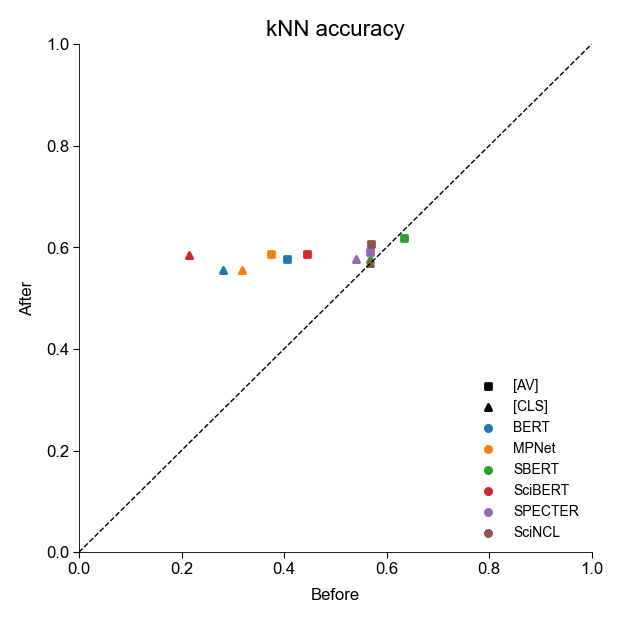

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

colormap = plt.get_cmap("tab10")
# rep = 1

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run3.npy")
    knn_accuracies_cls_after = np.load(
        variables_path / saving_path / "knn_accuracies_run3.npy"
    )
    knn_accuracies_av_after = np.load(
        variables_path / saving_path / "knn_accuracies_run1.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    color = colormap(i)

    # legend
    s_chosen = 5
    if i == 0:
        ax.plot([0, 1], [0, 1], color="k", linestyle="--")
        ax.scatter(
            [],
            [],
            marker="s",
            label=f"[AV]",
            color="k",
            s=s_chosen,
        )
        ax.scatter(
            [],
            [],
            marker="^",
            label=f"[CLS]",
            color="k",
            s=s_chosen,
        )

    ax.scatter(
        [],
        [],
        marker="o",
        label=f"{model_name}",
        color=color,
        s=s_chosen,
    )
    # real
    ax.scatter(
        knn_accuracies_before[1],
        knn_accuracies_cls_after[-1, 1],
        marker="^",
        color=color,
        s=s_chosen,
    )
    ax.scatter(
        knn_accuracies_before[0],
        knn_accuracies_av_after[-1, 0],
        marker="s",
        color=color,
        s=s_chosen,
    )
    # ax.text(
    #     knn_accuracies_before[rep],
    #     knn_accuracies_after[-1, rep],
    #     f"{model_name}",
    #     fontsize=5,
    #     va="bottom",
    #     ha="center",
    # )

    # ax.set_xticks(np.arange(2))
    # ax.set_xticklabels(["Before", "After"], rotation="vertical")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Before")
    ax.set_ylabel("After")
    ax.legend(loc="lower right")
    ax.set_title("kNN accuracy")
    # ax.axis("equal")


fig.savefig(
    figures_path / "loss_and_knn_accuracy_training_av_and_cls_fancy2_v1.png"
)

In [11]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]

In [12]:
colormap = plt.get_cmap("tab10")
dict_original_colors = dict()
for i, model_name in enumerate(model_names):
    color = colormap(i)
    dict_original_colors[model_name] = colormap(i)

In [13]:
# new order
model_names = [
    "MPNet",
    "BERT",
    "SciBERT",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SciNCL",
    "SPECTER",
    "SPECTER2",
    "SBERT",
]

In [14]:
6.75 * 3 / 4

5.0625

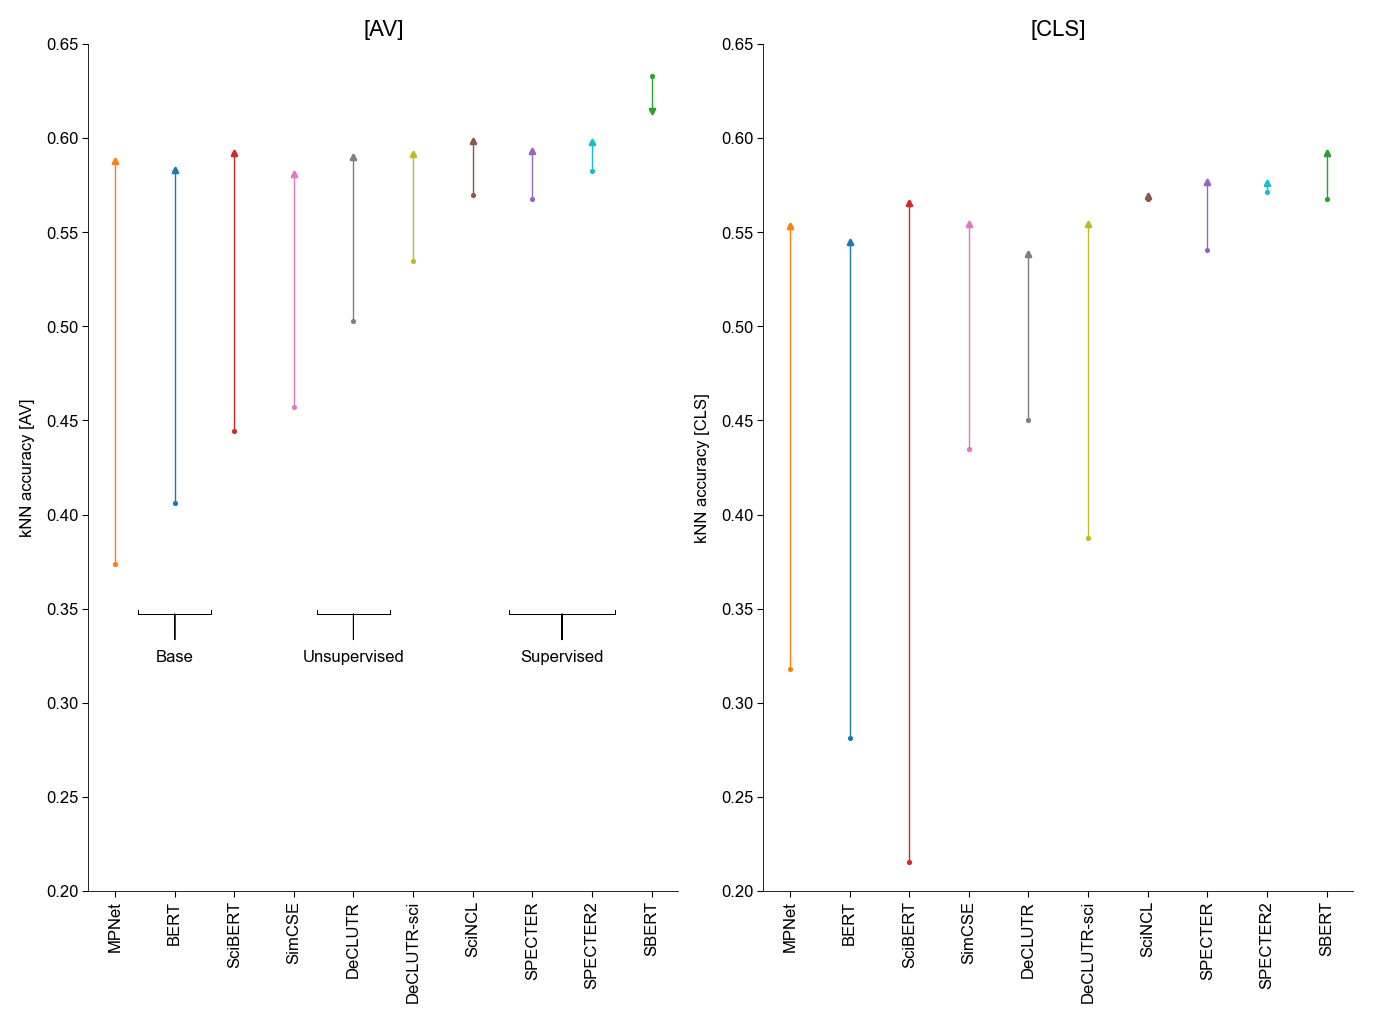

In [15]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(), dpi=200)

for i, model_name in enumerate(model_names):
    ## AV
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run1.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run1.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    color = dict_original_colors[model_name]
    rep = 0

    axs[0].plot(
        np.ones(2) * i,
        np.array([knn_accuracies_before[rep], knn_accuracies_after[0, rep]]),
        label=f"{model_name}",
        color=color,
        # marker=".",
        # ms=3,
    )
    axs[0].scatter(
        i,
        knn_accuracies_before[rep],
        color=color,
        marker=".",
        s=3,
    )
    if knn_accuracies_before[rep] <= knn_accuracies_after[0, rep]:
        axs[0].scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="^",
            s=3,
        )
    else:
        axs[0].scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="v",
            s=3,
        )

    axs[0].set_xticks(np.arange(len(model_names)))
    axs[0].set_xticklabels(model_names, rotation="vertical")
    axs[0].set_ylim(0.2, 0.65)
    axs[0].set_ylabel("kNN accuracy [AV]")
    # axs[0].legend(loc="lower right")
    axs[0].set_title("[AV]")
    axs[0].annotate(
        "Base",
        xy=(1, 0.35),
        xytext=(1, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=2.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )

    axs[0].annotate(
        "Unsupervised",
        xy=(4, 0.35),
        xytext=(4, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=2.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )

    axs[0].annotate(
        "Supervised",
        xy=(7.5, 0.35),
        xytext=(7.5, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=3.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )

    ## SEP
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run3.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run3.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    # color = dict_original_colors[model_name]
    rep = 1

    axs[1].plot(
        np.ones(2) * i,
        np.array([knn_accuracies_before[rep], knn_accuracies_after[0, rep]]),
        label=f"{model_name}",
        color=color,
        # marker=".",
        # ms=3,
    )
    axs[1].scatter(
        i,
        knn_accuracies_before[rep],
        color=color,
        marker=".",
        s=3,
    )
    if knn_accuracies_before[rep] <= knn_accuracies_after[0, rep]:
        axs[1].scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="^",
            s=3,
        )
    else:
        axs[1].scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="v",
            s=3,
        )

    axs[1].set_xticks(np.arange(len(model_names)))
    axs[1].set_xticklabels(model_names, rotation="vertical")
    axs[1].set_ylim(0.2, 0.65)
    axs[1].set_ylabel("kNN accuracy [CLS]")
    # axs[1].legend(loc="lower right")
    axs[1].set_title("[CLS]")


fig.savefig(
    figures_path / "loss_and_knn_accuracy_training_av_and_cls_fancy3_v1.png"
)

### Rerun sanity check
Reproducibility: if I run the same thing, do I get the same last knn acc value?

In [ ]:
model_names = [
    # "BERT",
    "MPNet",
    #     "SBERT",
    #     "SciBERT",
    #     "SPECTER",
    #     "SciNCL",
]


model_paths = [
    # "bert-base-uncased",
    "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model: ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="cls",
        n_epochs=2,
        lr=2e-5,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(variables_path / saving_path / "losses_run3_vsanitycheck", losses)
    np.save(
        variables_path / saving_path / "knn_accuracies_run3_vsanitycheck",
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 15min 33s, sys: 14min 46s, total: 30min 19s
Wall time: 17min 46s


In [ ]:
print(knn_accuracies)
print(knn_accuracies_old)

[array([0.57615385, 0.55307692, 0.57384615]), array([0.59076923, 0.55538462, 0.57923077])]
[[0.57615385 0.55307692 0.57384615]
 [0.59076923 0.55538462 0.57923077]]


In [ ]:
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

# losses = np.load(variables_path / saving_path / "losses_run3.npy")
knn_accuracies_old = np.load(
    variables_path / saving_path / "knn_accuracies_run3.npy"
)

In [ ]:
np.vstack(knn_accuracies_iclr_cls)[:, 1][-1]

0.553076923076923

In [ ]:
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
# (variables_path / saving_path).mkdir(exist_ok=True)

# losses_iclr = np.load(
#     variables_path
#     / saving_path
#     / "losses_batches_train_iclr_eval_iclr_v1.npy",
# )
# knn_accuracies_iclr_av = np.load(
#     variables_path
#     / saving_path
#     / "knn_accuracies_batches_train_iclr_eval_iclr_v1.npy",
# )
knn_accuracies_iclr_cls = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_cls_eval_iclr_v1.npy",
)

### Rerun for embeddings

In [ ]:
model_names = [
    # "BERT",
    "MPNet",
    #     "SBERT",
    #     "SciBERT",
    #     "SPECTER",
    #     "SciNCL",
]


model_paths = [
    # "bert-base-uncased",
    "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model: ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    (
        losses,
        knn_accuracies,
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="cls",
        n_epochs=1,
        lr=2e-5,
        return_embeddings=True,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(
        variables_path
        / saving_path
        / "embedding_asbtracts_only_cls_after_training_cls_1_epoch",
        embedding_cls,
    )
    np.save(
        variables_path
        / saving_path
        / "embedding_asbtracts_only_sep_after_training_cls_1_epoch",
        embedding_sep,
    )
    np.save(
        variables_path
        / saving_path
        / "embedding_asbtracts_only_av_after_training_cls_1_epoch",
        embedding_av,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 8min 31s, sys: 7min 53s, total: 16min 24s
Wall time: 8min 52s


In [ ]:
%%time
# t-SNE
tsne_cls = run_tsne_simple(embedding_cls)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
np.save(
    variables_path
    / saving_path
    / "tsne_asbtracts_only_cls_after_training_cls_1_epoch",
    tsne_cls,
)

/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


CPU times: user 2min, sys: 11.2 s, total: 2min 11s
Wall time: 1min 4s


## Training run4
Same as run 3 but with abstracts+ titles and only for MPNet

In [145]:
model_names = [
    # "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    # "bert-base-uncased",
    "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [147]:
%%time
for i, model_name in enumerate(model_names):
    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model: ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        pd.Series(titles_abstracts_together),
        tokenizer,
        device,
        n_cons_sntcs=2,
        seed=42,
    )

    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    (
        losses,
        knn_accuracies,
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = train_loop(
        model,
        training_loader,
        device,
        titles_abstracts_together,
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="cls",
        n_epochs=1,
        lr=2e-5,
        return_embeddings=True,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(variables_path / saving_path / "losses_run4", losses)
    np.save(
        variables_path / saving_path / "knn_accuracies_run4",
        knn_accuracies,
    )

    np.save(
        variables_path
        / saving_path
        / "embedding_cls_after_training_cls_1_epoch",
        embedding_cls,
    )
    np.save(
        variables_path
        / saving_path
        / "embedding_sep_after_training_cls_1_epoch",
        embedding_sep,
    )
    np.save(
        variables_path
        / saving_path
        / "embedding_av_after_training_cls_1_epoch",
        embedding_av,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 8min 51s, sys: 7min 52s, total: 16min 44s
Wall time: 9min


In [151]:
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
knn_accuracies_run3 = np.load(
    variables_path / saving_path / "knn_accuracies_run3.npy"
)

knn_accuracies_run4 = np.load(
    variables_path / saving_path / "knn_accuracies_run4.npy"
)

In [155]:
print("Without titles: ", knn_accuracies_run3[0])
print("With titles:    ", knn_accuracies_run4[0])

Without titles:  [0.57615385 0.55307692 0.57384615]
With titles:     [0.57615385 0.56384615 0.57923077]


In [148]:
%%time
# t-SNE
tsne_cls = run_tsne_simple(embedding_cls)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
np.save(
    variables_path / saving_path / "tsne_cls_after_training_cls_1_epoch",
    tsne_cls,
)

/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


CPU times: user 2min 8s, sys: 16.6 s, total: 2min 25s
Wall time: 1min 10s


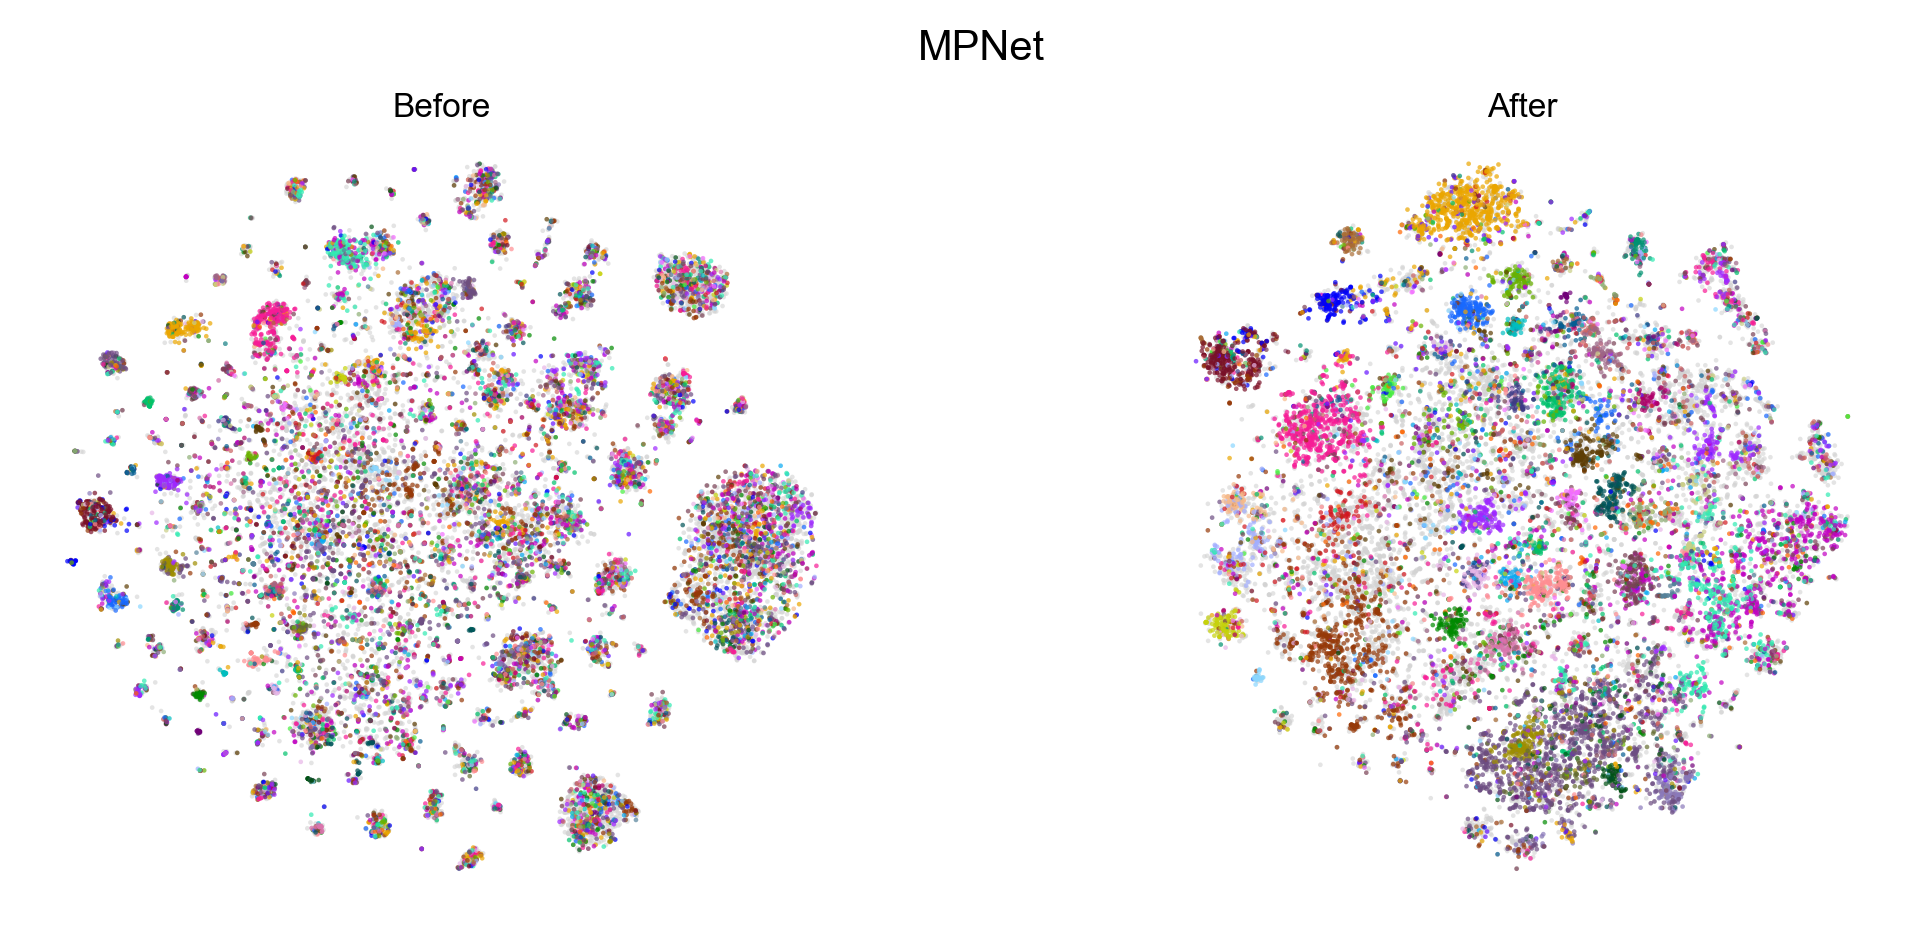

In [165]:
fig, ax = plt.subplots(1, 2, figsize=(7.2, 3), dpi=300)
xlim = (-70, 70)
ylim = (-70, 70)

# import tsne
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
tsne_cls = np.load(variables_path / saving_path / "tsne_cls.npy")

tsne_cls_after = np.load(
    variables_path
    / saving_path
    / "tsne_asbtracts_only_cls_after_training_cls_1_epoch.npy",
)

# 1
plot_tsne_colors(
    tsne_cls,
    colors_iclr,
    ax=ax[0],  # x_lim=xlim, y_lim=ylim
)
# plot_label_tags(
#     tsne_svd_n_comp_100,
#     colors,
#     dict_colors,
#     x_lim=xlim,
#     y_lim=ylim,
#     ax=ax[0],
#     subset=False,
#     fontsize=6,
# )
ax[0].set_title("Before")

# 2
plot_tsne_colors(
    tsne_cls_after,
    colors_iclr,
    ax=ax[1],  # x_lim=xlim, y_lim=ylim
)
# plot_label_tags(
#     tsne_svd_n_comp_100,
#     colors,
#     dict_colors,
#     x_lim=xlim,
#     y_lim=ylim,
#     ax=ax[1],
#     subset=False,
#     fontsize=6,
# )
ax[1].set_title(f"After")

fig.suptitle(f"{model_name}", fontsize=10)

fig.savefig(figures_path / f"tsne_cls_{model_name}_before_after_1_epoch.png")

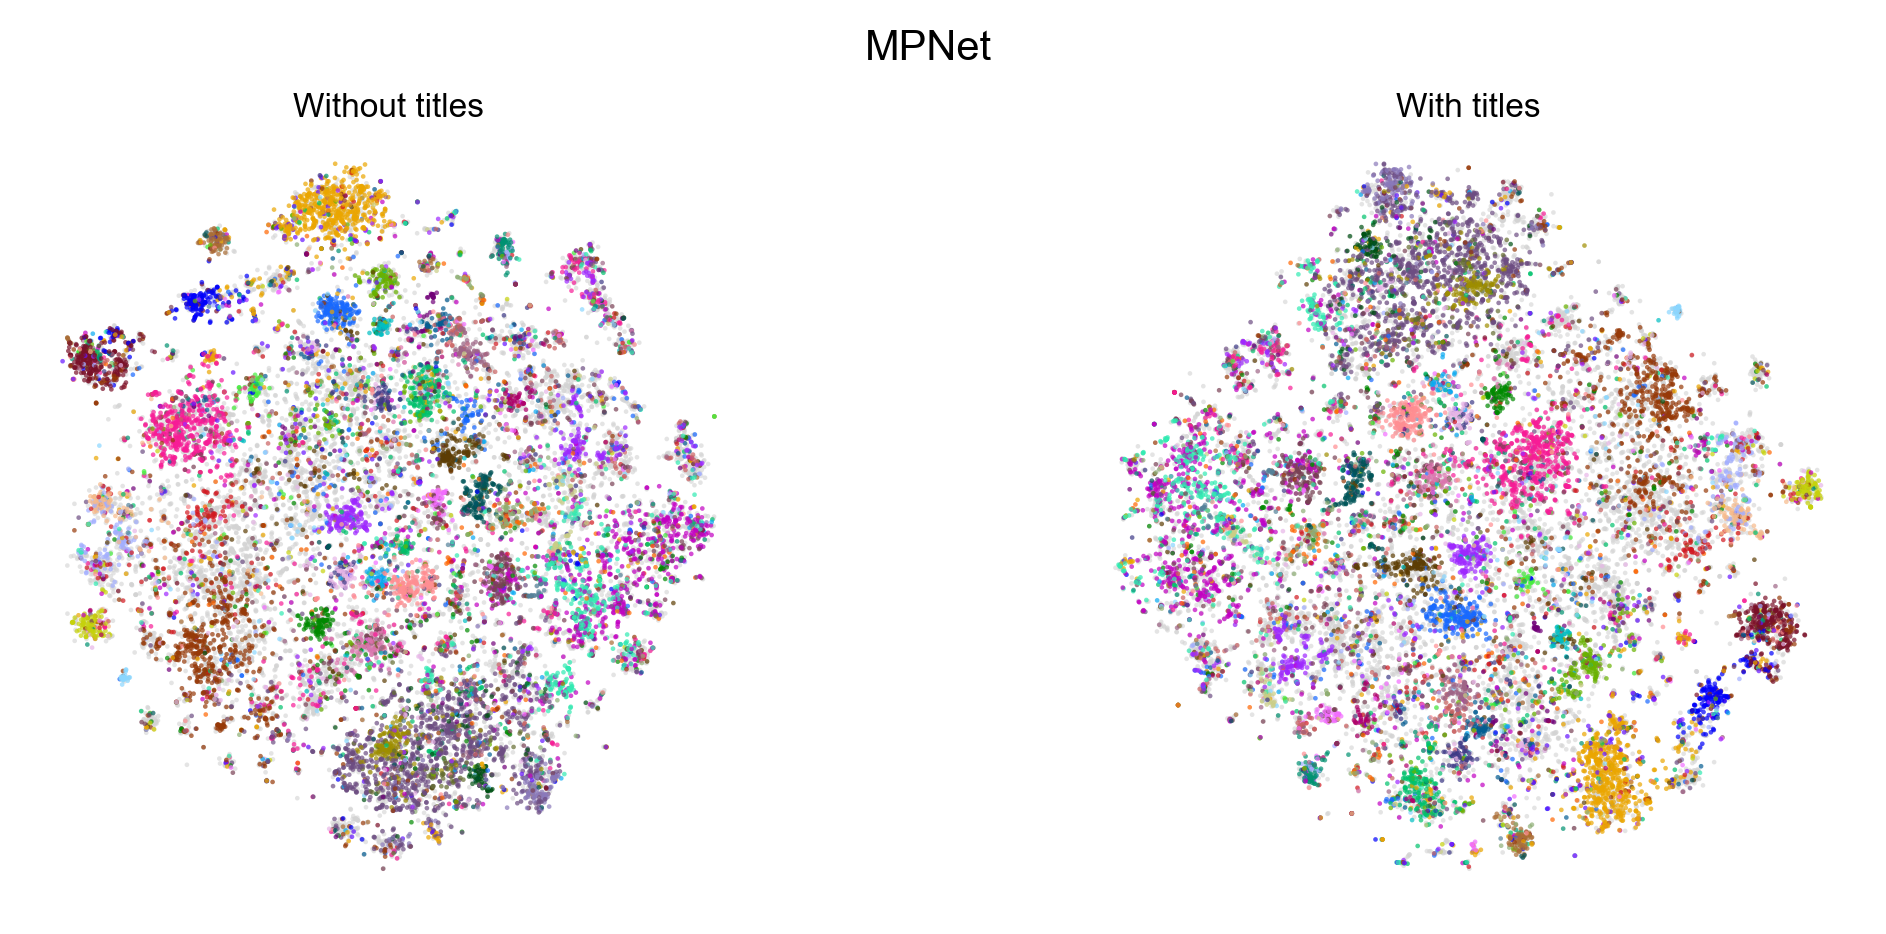

In [163]:
fig, ax = plt.subplots(1, 2, figsize=(7.2, 3), dpi=300)
xlim = (-90, 90)
ylim = (-90, 90)

# import tsne
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
tsne_cls = np.load(variables_path / saving_path / "tsne_cls.npy")

tsne_cls_without_titles = np.load(
    variables_path
    / saving_path
    / "tsne_asbtracts_only_cls_after_training_cls_1_epoch.npy",
)

tsne_cls_with_titles = np.load(
    variables_path / saving_path / "tsne_cls_after_training_cls_1_epoch.npy",
)

# 1
plot_tsne_colors(
    tsne_cls_without_titles,
    colors_iclr,
    ax=ax[0],  # x_lim=xlim, y_lim=ylim
)
# plot_label_tags(
#     tsne_svd_n_comp_100,
#     colors,
#     dict_colors,
#     x_lim=xlim,
#     y_lim=ylim,
#     ax=ax[0],
#     subset=False,
#     fontsize=6,
# )
ax[0].set_title("Without titles")

# 2
plot_tsne_colors(
    tsne_cls_with_titles,
    colors_iclr,
    ax=ax[1],  # x_lim=xlim, y_lim=ylim
)
# plot_label_tags(
#     tsne_svd_n_comp_100,
#     colors,
#     dict_colors,
#     x_lim=xlim,
#     y_lim=ylim,
#     ax=ax[1],
#     subset=False,
#     fontsize=6,
# )
ax[1].set_title(f"With titles")

fig.suptitle(f"{model_name}", fontsize=10)

fig.savefig(figures_path / f"tsne_cls_{model_name}_with_vs_without_titles.png")

## Training run5
Same as run 1 but with abstracts+ titles and only for MPNET

In [ ]:
model_names = [
    # "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    # "bert-base-uncased",
    "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [166]:
%%time
for i, model_name in enumerate(model_names):
    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model: ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        pd.Series(titles_abstracts_together),
        tokenizer,
        device,
        n_cons_sntcs=2,
        seed=42,
    )

    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    (
        losses,
        knn_accuracies,
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = train_loop(
        model,
        training_loader,
        device,
        titles_abstracts_together,
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="av",
        n_epochs=1,
        lr=2e-5,
        return_embeddings=True,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(variables_path / saving_path / "losses_run5", losses)
    np.save(
        variables_path / saving_path / "knn_accuracies_run5",
        knn_accuracies,
    )

    np.save(
        variables_path
        / saving_path
        / "embedding_cls_after_training_av_1_epoch",
        embedding_cls,
    )
    np.save(
        variables_path
        / saving_path
        / "embedding_sep_after_training_av_1_epoch",
        embedding_sep,
    )
    np.save(
        variables_path
        / saving_path
        / "embedding_av_after_training_av_1_epoch",
        embedding_av,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 9min 48s, sys: 7min 52s, total: 17min 40s
Wall time: 9min 7s


In [176]:
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
knn_accuracies_run1 = np.load(
    variables_path / saving_path / "knn_accuracies_run1.npy"
)

knn_accuracies_run5 = np.load(
    variables_path / saving_path / "knn_accuracies_run5.npy"
)

In [177]:
print("Without titles: ", knn_accuracies_run1[0])
print("With titles:    ", knn_accuracies_run5[0])

Without titles:  [0.58769231 0.51230769 0.54923077]
With titles:     [0.59153846 0.54769231 0.55615385]


In [175]:
%%time
# t-SNE
# load
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

embedding_av = np.load(
    variables_path
    / saving_path
    / "embedding_av_after_training_av_1_epoch.npy",
)

tsne_av = run_tsne_simple(embedding_av)

np.save(
    variables_path / saving_path / "tsne_av_after_training_av_1_epoch",
    tsne_av,
)

/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


CPU times: user 2min 3s, sys: 17.2 s, total: 2min 20s
Wall time: 1min 7s


In [195]:
%%time
tsne_av_without_titles = np.load(
    variables_path
    / saving_path
    / "tsne_abstracts_only_av_after_training_av_1_epoch.npy",
)

tsne_av_with_titles = np.load(
    variables_path / saving_path / "tsne_av_after_training_av_1_epoch.npy",
)
knn_acc_without_titles = knn_accuracy(
    [
        tsne_av_without_titles[labels_iclr != "unlabeled"],
    ],
    labels_iclr[labels_iclr != "unlabeled"],
)
knn_acc_with_titles = knn_accuracy(
    [
        tsne_av_with_titles[labels_iclr != "unlabeled"],
    ],
    labels_iclr[labels_iclr != "unlabeled"],
)

CPU times: user 1.18 s, sys: 70.3 ms, total: 1.26 s
Wall time: 70.1 ms


In [196]:
knn_acc_without_titles

array([0.53230769])

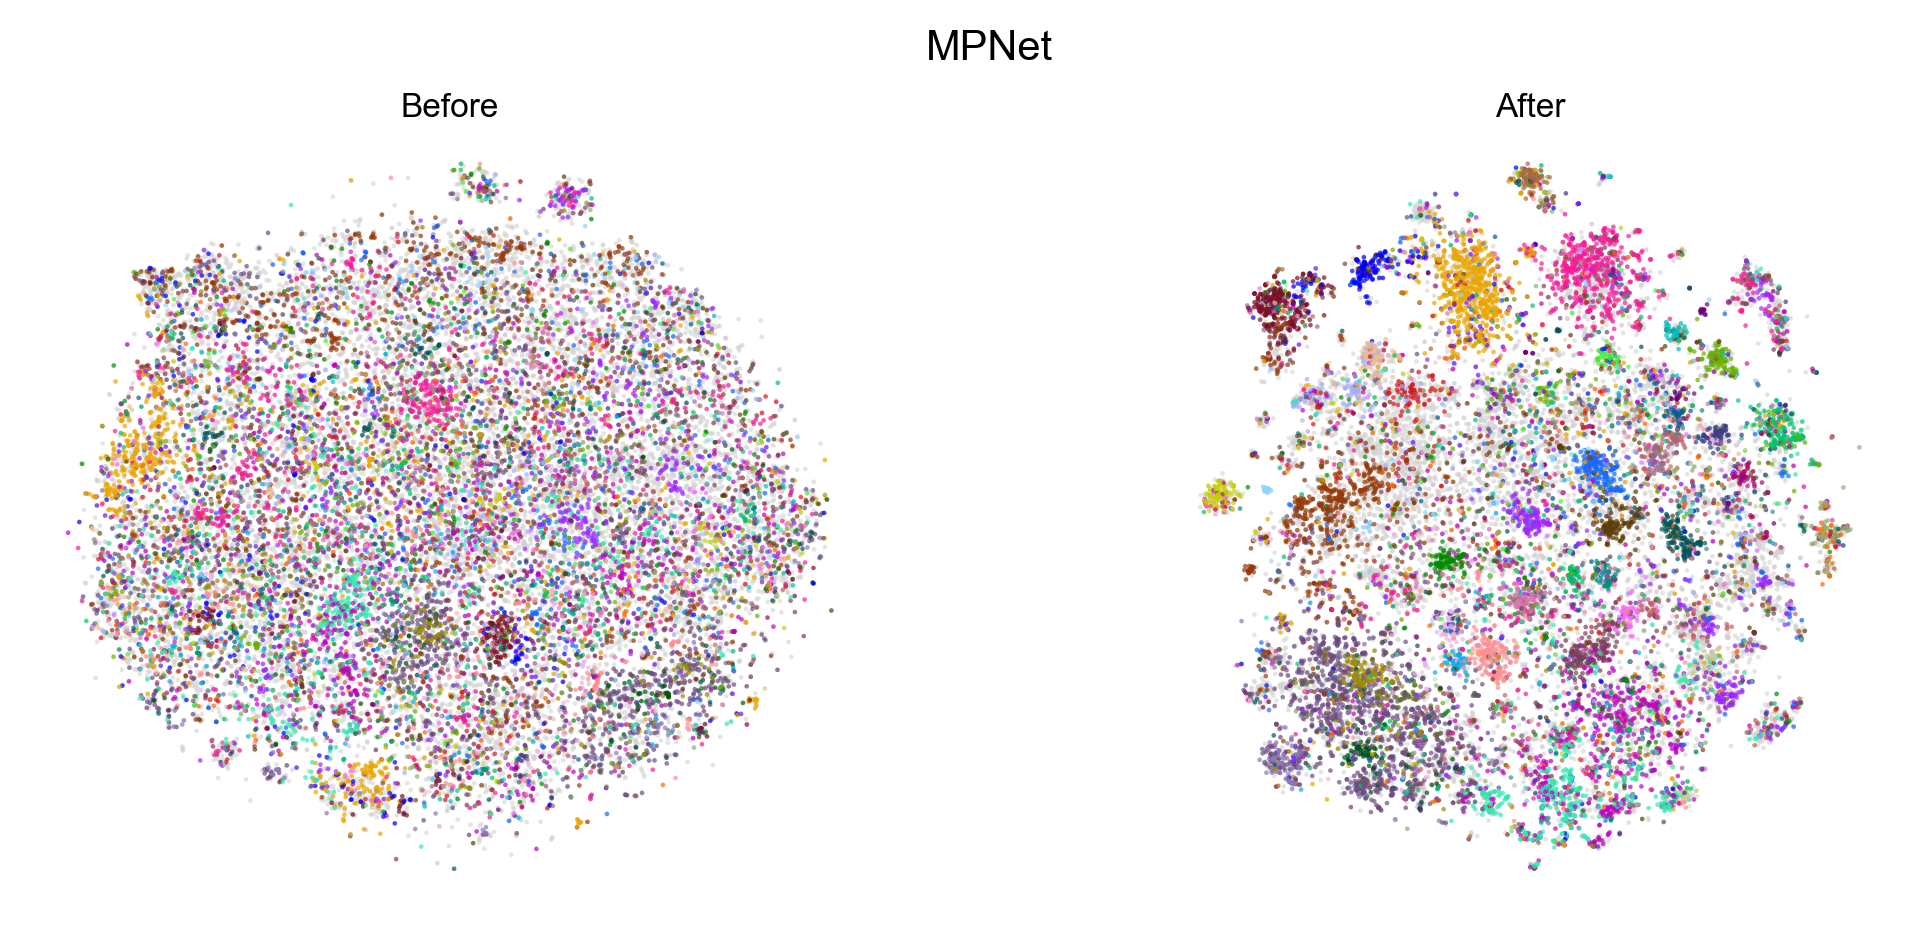

In [185]:
fig, ax = plt.subplots(1, 2, figsize=(7.2, 3), dpi=300)
xlim = (-70, 70)
ylim = (-70, 70)

# import tsne
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
tsne_av = np.load(variables_path / saving_path / "tsne_av.npy")

tsne_av_after = np.load(
    variables_path
    / saving_path
    / "tsne_abstracts_only_av_after_training_av_1_epoch.npy",
)

# 1
plot_tsne_colors(
    tsne_av,
    colors_iclr,
    ax=ax[0],  # x_lim=xlim, y_lim=ylim
)
# plot_label_tags(
#     tsne_svd_n_comp_100,
#     colors,
#     dict_colors,
#     x_lim=xlim,
#     y_lim=ylim,
#     ax=ax[0],
#     subset=False,
#     fontsize=6,
# )
ax[0].set_title("Before")

# 2
plot_tsne_colors(
    tsne_av_after,
    colors_iclr,
    ax=ax[1],  # x_lim=xlim, y_lim=ylim
)
# plot_label_tags(
#     tsne_svd_n_comp_100,
#     colors,
#     dict_colors,
#     x_lim=xlim,
#     y_lim=ylim,
#     ax=ax[1],
#     subset=False,
#     fontsize=6,
# )
ax[1].set_title(f"After")

fig.suptitle(f"{model_name}", fontsize=10)

fig.savefig(figures_path / f"tsne_av_{model_name}_before_after_1_epoch.png")

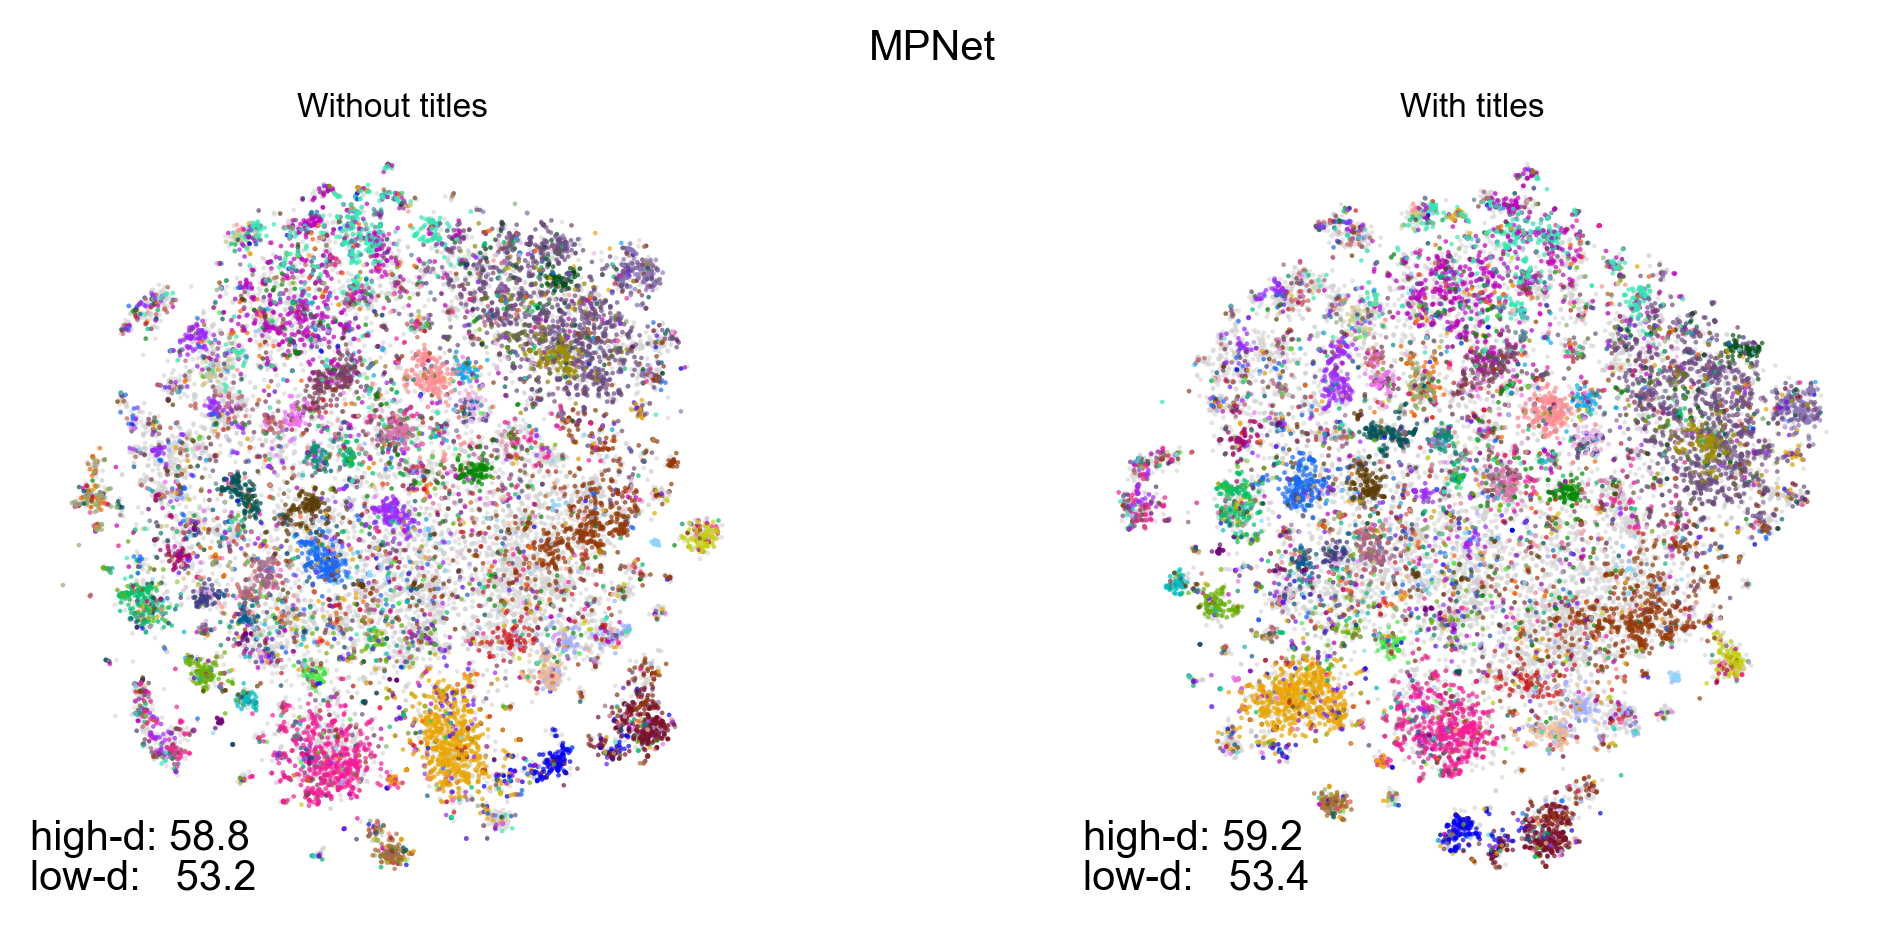

In [200]:
fig, ax = plt.subplots(1, 2, figsize=(7.2, 3), dpi=300)
xlim = (-90, 90)
ylim = (-90, 90)

# import tsne
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
tsne_av = np.load(variables_path / saving_path / "tsne_av.npy")

tsne_av_without_titles = np.load(
    variables_path
    / saving_path
    / "tsne_abstracts_only_av_after_training_av_1_epoch.npy",
)

tsne_av_with_titles = np.load(
    variables_path / saving_path / "tsne_av_after_training_av_1_epoch.npy",
)

knn_accuracies_run1 = np.load(
    variables_path / saving_path / "knn_accuracies_run1.npy"
)

knn_accuracies_run5 = np.load(
    variables_path / saving_path / "knn_accuracies_run5.npy"
)

# 1
plot_tsne_colors(
    np.vstack(
        (-tsne_av_without_titles[:, 0], -tsne_av_without_titles[:, 1])
    ).T,
    colors_iclr,
    ax=ax[0],  # x_lim=xlim, y_lim=ylim
)
ax[0].text(
    0,
    0.06,
    f"high-d: {knn_accuracies_run1[0][0]*100:.1f}",
    transform=ax[0].transAxes,
    va="bottom",
    ha="left",
    size=10,
)
knn_acc_lowd = knn_accuracy(
    tsne_av_without_titles[labels_iclr != "unlabeled"],
    labels_iclr[labels_iclr != "unlabeled"],
)
ax[0].text(
    0,
    0.01,
    f"low-d:   {knn_acc_lowd*100:.1f}",
    transform=ax[0].transAxes,
    va="bottom",
    ha="left",
    size=10,
)
ax[0].set_title("Without titles")

# 2
plot_tsne_colors(
    tsne_av_with_titles,
    colors_iclr,
    ax=ax[1],  # x_lim=xlim, y_lim=ylim
)
ax[1].text(
    0,
    0.06,
    f"high-d: {knn_accuracies_run5[0][0]*100:.1f}",
    transform=ax[1].transAxes,
    va="bottom",
    ha="left",
    size=10,
)
knn_acc_lowd = knn_accuracy(
    tsne_av_with_titles[labels_iclr != "unlabeled"],
    labels_iclr[labels_iclr != "unlabeled"],
)
ax[1].text(
    0,
    0.01,
    f"low-d:   {knn_acc_lowd*100:.1f}",
    transform=ax[1].transAxes,
    va="bottom",
    ha="left",
    size=10,
)
ax[1].set_title(f"With titles")

fig.suptitle(f"{model_name}", fontsize=10)

fig.savefig(figures_path / f"tsne_av_{model_name}_with_vs_without_titles.png")

# Measure time

### Optimize for AV

In [16]:
import torch

# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

# from transformers import AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import mean_pool

In [17]:
model_names = [
    "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    #     "sentence-transformers/all-mpnet-base-v2",
    #     "allenai/scibert_scivocab_uncased",
    #     "allenai/specter",
    #     "malteos/scincl",
]

In [18]:
%%time

i = 1
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("Training loader length: ", len(training_loader))


##  train_loop_batches_eval
loader = training_loader
titles_abstracts_together = iclr2024.abstract.to_list()
# tokenizer =
label_mask = labels_iclr != "unlabeled"
labels_acc = labels_iclr[labels_iclr != "unlabeled"]
optimized_rep = "av"
n_epochs = 1
lr = 2e-5
eval_metric = "knn"
return_seventh = False

start = time.time()

model.to(device)

# define layers to be used in multiple-negatives-ranking
cos_sim = torch.nn.CosineSimilarity()
loss_func = torch.nn.CrossEntropyLoss()
scale = 20.0  # we multiply similarity score by this scale value
# move layers to device
cos_sim.to(device)
loss_func.to(device)

# initialize Adam optimizer
optim = torch.optim.Adam(model.parameters(), lr=lr)

# setup warmup for first ~10% of steps
total_steps = len(loader) * n_epochs
warmup_steps = int(0.1 * len(loader))
scheduler = get_linear_schedule_with_warmup(
    optim,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

losses = np.empty((n_epochs, len(loader)))

for epoch in range(n_epochs):
    model.train()  # make sure model is in training mode
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    loop = tqdm(loader, leave=True)
    for i_batch, batch in enumerate(loop):
        # zero all gradients on each new step
        optim.zero_grad()
        # prepare batches and more all to the active device
        anchor_ids = batch[0][0].to(device)
        anchor_mask = batch[0][1].to(device)
        pos_ids = batch[1][0].to(device)
        pos_mask = batch[1][1].to(device)
        # extract token embeddings from BERT
        a = model(anchor_ids, attention_mask=anchor_mask)[
            0
        ]  # all token embeddings
        p = model(pos_ids, attention_mask=pos_mask)[0]

        # get the mean pooled vectors
        if optimized_rep == "av":
            a = mean_pool(a, anchor_mask)
            p = mean_pool(p, pos_mask)

        elif optimized_rep == "cls":
            a = cls_pool(a, anchor_mask)
            p = cls_pool(p, pos_mask)

        elif optimized_rep == "sep":
            a = sep_pool(a, anchor_mask)
            p = sep_pool(p, pos_mask)

        elif optimized_rep == "7th":
            a = seventh_pool(a, anchor_mask)
            p = seventh_pool(p, pos_mask)

        # calculate the cosine similarities
        scores = torch.stack(
            [cos_sim(a_i.reshape(1, a_i.shape[0]), p) for a_i in a]
        )
        # get label(s) - we could define this before if confident
        # of consistent batch sizes
        labels = torch.tensor(
            range(len(scores)), dtype=torch.long, device=scores.device
        )
        # and now calculate the loss
        loss = loss_func(
            scores * scale, labels
        )  # Nik does not know what the labels nor the scale are
        losses[epoch, i_batch] = loss.item()

        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()
        # update learning rate scheduler
        scheduler.step()
        # update the TDQM progress bar
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

        if i_batch == 100:
            end = time.time()
            runtime_100_batches = end - start

end = time.time()
runtime_total = end - start

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Training loader length:  368


  0%|          | 0/368 [00:00<?, ?it/s]

CPU times: user 5min 42s, sys: 3min 59s, total: 9min 41s
Wall time: 5min 20s


In [19]:
print(runtime_100_batches)
print(runtime_total)

83.22728538513184
306.0830955505371


In [21]:
print(runtime_100_batches / 60)
print((runtime_100_batches / 60 - 1) * 60)

1.3871214230855307
23.22728538513184


In [24]:
print(runtime_total / 60)
print((runtime_total / 60 - 5) * 60)

5.101384925842285
6.083095550537099


In [25]:
print("Runtime 100 batches: 1 min 23 s")
print("Runtime total: 5 min 6 s")

Runtime 100 batches: 1 min 23 s
Runtime total: 5 min 6 s


# Randomly initialized model

## Test model

In [40]:
from transformers import BertConfig, BertModel

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [41]:
model_random

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [42]:
for name, param in model_random.named_parameters():
    print(f"{name}: {param.requires_grad}")

embeddings.word_embeddings.weight: True
embeddings.position_embeddings.weight: True
embeddings.token_type_embeddings.weight: True
embeddings.LayerNorm.weight: True
embeddings.LayerNorm.bias: True
encoder.layer.0.attention.self.query.weight: True
encoder.layer.0.attention.self.query.bias: True
encoder.layer.0.attention.self.key.weight: True
encoder.layer.0.attention.self.key.bias: True
encoder.layer.0.attention.self.value.weight: True
encoder.layer.0.attention.self.value.bias: True
encoder.layer.0.attention.output.dense.weight: True
encoder.layer.0.attention.output.dense.bias: True
encoder.layer.0.attention.output.LayerNorm.weight: True
encoder.layer.0.attention.output.LayerNorm.bias: True
encoder.layer.0.intermediate.dense.weight: True
encoder.layer.0.intermediate.dense.bias: True
encoder.layer.0.output.dense.weight: True
encoder.layer.0.output.dense.bias: True
encoder.layer.0.output.LayerNorm.weight: True
encoder.layer.0.output.LayerNorm.bias: True
encoder.layer.1.attention.self.query

In [43]:
model_random.encoder.layer[0].attention.self.query.weight
model_random.encoder.layer[0].attention.self.query.weight.shape

torch.Size([768, 768])

### Comparison to trained BERT

In [44]:
model_names = [
    "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [45]:
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Set the random seed for NumPy
np.random.seed(seed)

# Set the random seed
random.seed(seed)

In [46]:
# initialize
i = 0

# random_state = random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

Running on device: cuda
bert-base-uncased


In [47]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

embeddings.word_embeddings.weight: True
embeddings.position_embeddings.weight: True
embeddings.token_type_embeddings.weight: True
embeddings.LayerNorm.weight: True
embeddings.LayerNorm.bias: True
encoder.layer.0.attention.self.query.weight: True
encoder.layer.0.attention.self.query.bias: True
encoder.layer.0.attention.self.key.weight: True
encoder.layer.0.attention.self.key.bias: True
encoder.layer.0.attention.self.value.weight: True
encoder.layer.0.attention.self.value.bias: True
encoder.layer.0.attention.output.dense.weight: True
encoder.layer.0.attention.output.dense.bias: True
encoder.layer.0.attention.output.LayerNorm.weight: True
encoder.layer.0.attention.output.LayerNorm.bias: True
encoder.layer.0.intermediate.dense.weight: True
encoder.layer.0.intermediate.dense.bias: True
encoder.layer.0.output.dense.weight: True
encoder.layer.0.output.dense.bias: True
encoder.layer.0.output.LayerNorm.weight: True
encoder.layer.0.output.LayerNorm.bias: True
encoder.layer.1.attention.self.query

In [48]:
model.encoder.layer[
    0
].attention.self.query.weight == model_random.encoder.layer[
    0
].attention.self.query.weight

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [49]:
print(
    model.encoder.layer[0].attention.self.query.weight
    == model_random.encoder.layer[0].attention.self.query.weight
)
print(
    model.embeddings.word_embeddings.weight
    == model_random.embeddings.word_embeddings.weight
)
print(
    model.embeddings.position_embeddings.weight
    == model_random.embeddings.position_embeddings.weight
)
print(
    model.embeddings.token_type_embeddings.weight
    == model_random.embeddings.token_type_embeddings.weight
)

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  

## Baseline

In [51]:
%%time

model_name = "random_bert"
# set up model
print('Model: ', model_name)

random_state = random.seed(42)
device = (
    "cuda" if torch.cuda.is_available() else "cpu"
)  
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config

model = model.to(device)

# get embeddings
embedding_cls, embedding_sep, embedding_av = generate_embeddings(iclr2024.abstract.to_list(), tokenizer, model, device, batch_size=256)

# save embeddings
saving_path = Path("embeddings_" + model_name.lower()) / Path("updated_dataset")
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path/saving_path/"embedding_abstracts_only_cls", embedding_cls)
np.save(variables_path/saving_path/"embedding_abstracts_only_sep", embedding_sep)
np.save(variables_path/saving_path/"embedding_abstracts_only_av", embedding_av)

model = None
gc.collect()
torch.cuda.empty_cache()

print('----------------------------')



Model:  random_bert
Running on device: cuda


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 1min 27s, sys: 2min 58s, total: 4min 26s
Wall time: 3min 17s


### kNN accuracy

In [52]:
%%time
%%memit
print("kNN accuracy     [AVG]    [CLS]   [SEP]")
model_name = "random_bert"


# import
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

embedding_cls = np.load(
    variables_path / saving_path / "embedding_abstracts_only_cls.npy"
)
embedding_sep = np.load(
    variables_path / saving_path / "embedding_abstracts_only_sep.npy"
)
embedding_av = np.load(
    variables_path / saving_path / "embedding_abstracts_only_av.npy"
)

# print(type(embedding_av))

# knn acc
knn_acc = knn_accuracy(
    [
        embedding_av[labels_iclr != "unlabeled"],
        embedding_cls[labels_iclr != "unlabeled"],
        embedding_sep[labels_iclr != "unlabeled"],
    ],
    labels_iclr[labels_iclr != "unlabeled"],
)
print(f"{model_name}: {np.array(knn_acc)*100}")

# save embeddings
saving_name = Path("knn_accuracy_" + model_name.lower())
np.save(variables_path / "updated_dataset" / saving_name, knn_acc)

# print("----------------------------")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


kNN accuracy     [AVG]    [CLS]   [SEP]
random_bert: [30.84615385 30.53846154  9.46153846]
peak memory: 9033.46 MiB, increment: 5.45 MiB
CPU times: user 9.29 s, sys: 5.1 s, total: 14.4 s
Wall time: 2.04 s


### Linear accuracy

In [37]:
%%time
print("Linear accuracy     [AVG]    [CLS]   [SEP]")
model_name = "random_bert"

# load
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

embedding_av = np.load(
    variables_path / saving_path / "embedding_abstracts_only_cls.npy"
)
embedding_cls = np.load(
    variables_path / saving_path / "embedding_abstracts_only_sep.npy"
)
embedding_sep = np.load(
    variables_path / saving_path / "embedding_abstracts_only_av.npy"
)

# metric
accuracy = logistic_accuracy(
    [
        embedding_av[labels_iclr != "unlabeled"],
        embedding_cls[labels_iclr != "unlabeled"],
        embedding_sep[labels_iclr != "unlabeled"],
    ],
    labels_iclr[labels_iclr != "unlabeled"],
)
print(f"{model_name}: {np.array(accuracy)*100}")

# save
np.save(variables_path / saving_path / "linear_accuracy", accuracy)

Linear accuracy     [AVG]    [CLS]   [SEP]
random_bert: [50.92307692 35.61538462 50.76923077]
CPU times: user 5min 4s, sys: 14.5 s, total: 5min 18s
Wall time: 5min 7s


## Training run1
Optimize the [av] representation for 1 epochs for randomly initialized model. batch_size=64, lr=2e-5.

Data augmentation (MultSentencesPairDataset), with n_cons_sntcs=2.

In [16]:
from transformers import BertConfig, BertModel

In [17]:
%%time
model_name = "random_bert"

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run1",
    knn_accuracies,
)

# clean up
model = None
tokenizer = None
gc.collect()
torch.cuda.empty_cache()

print("----------------------------")

Model:  random_bert
Running on device: cuda


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

### Fancier plots

In [19]:
model_names = [
    "random_bert",
    "BERT",
    "MPNet",
    # "SBERT",
    "SciBERT",
    # "SPECTER",
    # "SciNCL",
    # "SimCSE",
    # "DeCLUTR",
    # "DeCLUTR-sci",
    # "SPECTER2",
]

[0.30846154 0.30538462 0.09461538]
[[0.47076923 0.45846154 0.19230769]
 [0.49846154 0.48769231 0.20769231]
 [0.54       0.51461538 0.21153846]
 [0.53769231 0.51692308 0.21923077]
 [0.56       0.53230769 0.22461538]
 [0.55538462 0.53461538 0.22307692]
 [0.55692308 0.54307692 0.22384615]
 [0.55923077 0.53615385 0.22384615]
 [0.56153846 0.53384615 0.22692308]
 [0.57076923 0.53769231 0.22461538]]


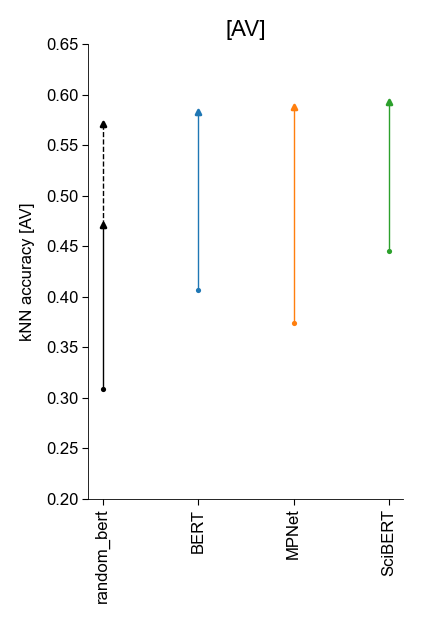

In [27]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2, 3), dpi=200, layout="constrained")

colormap = plt.get_cmap("tab10")
rep = 0  # av

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run1.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run1.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )
    if i == 0:
        color = "k"
    else:
        color = colormap(i - 1)

    ax.plot(
        np.ones(2) * i,
        np.array([knn_accuracies_before[rep], knn_accuracies_after[0, rep]]),
        label=f"{model_name}",
        color=color,
        # marker=".",
        # ms=3,
    )
    ax.scatter(
        i,
        knn_accuracies_before[rep],
        color=color,
        marker=".",
        s=3,
    )
    if knn_accuracies_before[rep] <= knn_accuracies_after[0, rep]:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="^",
            s=3,
        )
    else:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="v",
            s=3,
        )
    if model_name == "random_bert":
        print(knn_accuracies_before)
        print(knn_accuracies_after)
        ax.plot(
            np.ones(2) * i,
            np.array(
                [knn_accuracies_after[0, rep], knn_accuracies_after[-1, rep]]
            ),
            label=f"{model_name}",
            color=color,
            linestyle="--",
            # marker=".",
            # ms=3,
        )
        ax.scatter(
            i,
            knn_accuracies_after[-1, rep],
            color=color,
            marker="^",
            s=3,
        )

    ax.set_xticks(np.arange(len(model_names)))
    ax.set_xticklabels(model_names, rotation="vertical")
    ax.set_ylim(0.2, 0.65)
    ax.set_ylabel("kNN accuracy [AV]")
    # ax.legend(loc="lower right")
    ax.set_title("[AV]")


fig.savefig(
    figures_path
    / "loss_and_knn_accuracy_training_run1_fancy3_with_random_bert_v1.png"
)

## Training run3
Optimize the [CLS] representation for 1 epochs for randomly initialized model. batch_size=64, lr=2e-5.

Data augmentation (MultSentencesPairDataset), with n_cons_sntcs=2.

In [28]:
from transformers import BertConfig, BertModel

In [29]:
%%time
model_name = "random_bert"

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="cls",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run3", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run3",
    knn_accuracies,
)

# clean up
model = None
tokenizer = None
gc.collect()
torch.cuda.empty_cache()

print("----------------------------")

Model:  random_bert
Running on device: cuda


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 32min 47s, sys: 1h 6min 57s, total: 1h 39min 44s
Wall time: 1h 24min 10s


### Fancier plots

In [30]:
model_names = [
    "random_bert",
    "BERT",
    "MPNet",
    # "SBERT",
    "SciBERT",
    # "SPECTER",
    # "SciNCL",
    # "SimCSE",
    # "DeCLUTR",
    # "DeCLUTR-sci",
    # "SPECTER2",
]

[0.30846154 0.30538462 0.09461538]
[[0.27769231 0.27846154 0.16153846]
 [0.41461538 0.43615385 0.26307692]
 [0.47692308 0.48846154 0.30538462]
 [0.49846154 0.51230769 0.34461538]
 [0.52230769 0.52307692 0.33692308]
 [0.50846154 0.53846154 0.33846154]
 [0.51461538 0.55076923 0.34230769]
 [0.51076923 0.54846154 0.34538462]
 [0.52692308 0.54769231 0.34692308]
 [0.52       0.54923077 0.35307692]]


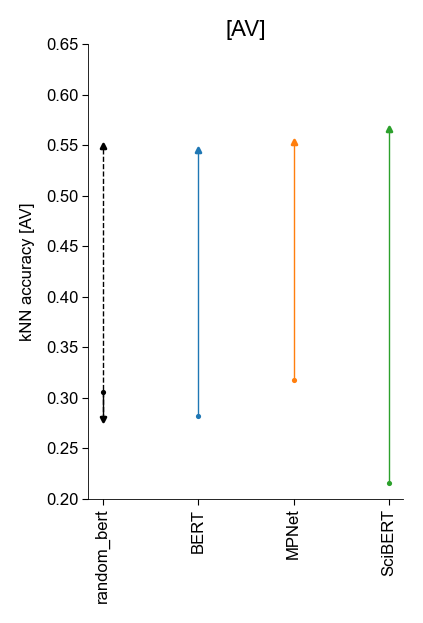

In [31]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2, 3), dpi=200, layout="constrained")

colormap = plt.get_cmap("tab10")
rep = 1  # av

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run3.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run3.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )
    if i == 0:
        color = "k"
    else:
        color = colormap(i - 1)

    ax.plot(
        np.ones(2) * i,
        np.array([knn_accuracies_before[rep], knn_accuracies_after[0, rep]]),
        label=f"{model_name}",
        color=color,
        # marker=".",
        # ms=3,
    )
    ax.scatter(
        i,
        knn_accuracies_before[rep],
        color=color,
        marker=".",
        s=3,
    )
    if knn_accuracies_before[rep] <= knn_accuracies_after[0, rep]:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="^",
            s=3,
        )
    else:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="v",
            s=3,
        )
    if model_name == "random_bert":
        print(knn_accuracies_before)
        print(knn_accuracies_after)
        ax.plot(
            np.ones(2) * i,
            np.array(
                [knn_accuracies_after[0, rep], knn_accuracies_after[-1, rep]]
            ),
            label=f"{model_name}",
            color=color,
            linestyle="--",
            # marker=".",
            # ms=3,
        )
        ax.scatter(
            i,
            knn_accuracies_after[-1, rep],
            color=color,
            marker="^",
            s=3,
        )

    ax.set_xticks(np.arange(len(model_names)))
    ax.set_xticklabels(model_names, rotation="vertical")
    ax.set_ylim(0.2, 0.65)
    ax.set_ylabel("kNN accuracy [AV]")
    # ax.legend(loc="lower right")
    ax.set_title("[AV]")


fig.savefig(
    figures_path
    / "loss_and_knn_accuracy_training_run3_fancy3_with_random_bert_v1.png"
)

[[0.27769231 0.27846154 0.16153846]
 [0.41461538 0.43615385 0.26307692]
 [0.47692308 0.48846154 0.30538462]
 [0.49846154 0.51230769 0.34461538]
 [0.52230769 0.52307692 0.33692308]
 [0.50846154 0.53846154 0.33846154]
 [0.51461538 0.55076923 0.34230769]
 [0.51076923 0.54846154 0.34538462]
 [0.52692308 0.54769231 0.34692308]
 [0.52       0.54923077 0.35307692]]


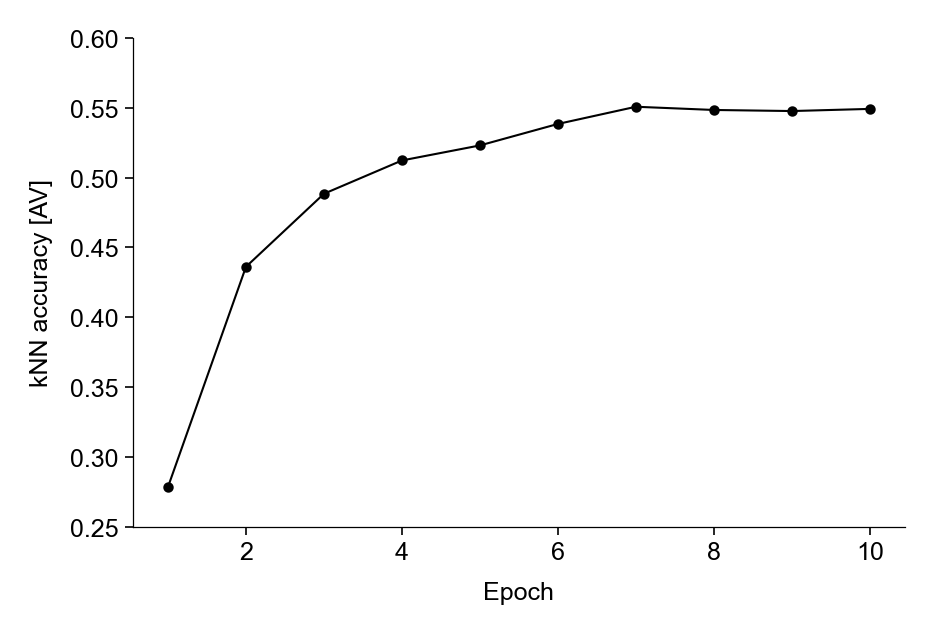

In [35]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3, 2), dpi=300, layout="constrained")

colormap = plt.get_cmap("tab10")
rep = 1  # av
model_name = "random_bert"

# for i, model_name in enumerate(model_names):
# load things
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

losses = np.load(variables_path / saving_path / "losses_run3.npy")
knn_accuracies_after = np.load(
    variables_path / saving_path / "knn_accuracies_run3.npy"
)

saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_accuracies_before = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
print(knn_accuracies_after)

ax.plot(
    np.arange(10) + 1,
    knn_accuracies_after[:, rep],
    # label=f"{model_name}",
    color="k",
    marker=".",
    ms=3,
)

# ax.set_xticks(np.arange(len(model_names)))
# ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylim(0.25, 0.6)
ax.set_ylabel("kNN accuracy [AV]")
ax.set_xlabel("Epoch")
# ax.set_xlim(0.35, 0.6)
# ax.legend(loc="lower right")
# ax.set_title("[AV]")


fig.savefig(
    figures_path / "knn_accuracy_training_run3_with_random_bert_v1.png"
)

## Training run1 linear accuracy
Optimize the [av] representation for 1 epochs for randomly initialized model. batch_size=64, lr=2e-5.

Data augmentation (MultSentencesPairDataset), with n_cons_sntcs=2.

In [ ]:
from transformers import BertConfig, BertModel

In [38]:
%%time
model_name = "random_bert"

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, accuracies = train_loop(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
    eval_metric="lin",
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path / saving_path / "losses_run6", losses)
np.save(
    variables_path / saving_path / "linear_accuracy_run6",
    accuracies,
)

# clean up
model = None
tokenizer = None
gc.collect()
torch.cuda.empty_cache()

print("----------------------------")

Model:  random_bert
Running on device: cuda


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

### Fancier plots

In [ ]:
model_names = [
    "random_bert",
    "BERT",
    "MPNet",
    # "SBERT",
    "SciBERT",
    # "SPECTER",
    # "SciNCL",
    # "SimCSE",
    # "DeCLUTR",
    # "DeCLUTR-sci",
    # "SPECTER2",
]

[0.50923077 0.35615385 0.50769231]
[[0.56       0.51       0.45769231]
 [0.58       0.52923077 0.46461538]
 [0.57538462 0.53692308 0.47      ]
 [0.57769231 0.53923077 0.48461538]
 [0.57615385 0.53846154 0.48846154]
 [0.57846154 0.54153846 0.49692308]
 [0.57846154 0.54153846 0.49461538]
 [0.58307692 0.54461538 0.49923077]
 [0.58076923 0.54307692 0.50230769]
 [0.58230769 0.54153846 0.50384615]]


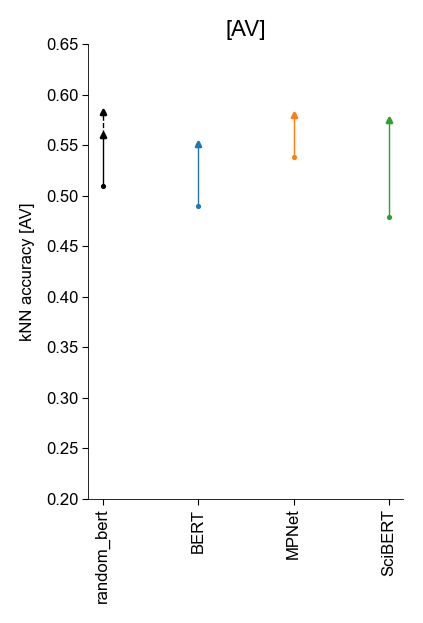

In [39]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2, 3), dpi=200, layout="constrained")

colormap = plt.get_cmap("tab10")
rep = 0  # av

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    accuracies_after = np.load(
        variables_path / saving_path / "linear_accuracy_run6.npy"
    )
    accuracy_before = np.load(
        variables_path / saving_path / "linear_accuracy.npy"
    )
    # knn_accuracies_after = np.load(
    #     variables_path / saving_path / "linear_accuracy_run6.npy"
    # )

    # saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    # knn_accuracies_before = np.load(
    #     variables_path / "updated_dataset" / saving_name_2
    # )
    if i == 0:
        color = "k"
    else:
        color = colormap(i - 1)

    ax.plot(
        np.ones(2) * i,
        np.array([accuracy_before[rep], accuracies_after[0, rep]]),
        label=f"{model_name}",
        color=color,
        # marker=".",
        # ms=3,
    )
    ax.scatter(
        i,
        accuracy_before[rep],
        color=color,
        marker=".",
        s=3,
    )
    if accuracy_before[rep] <= accuracies_after[0, rep]:
        ax.scatter(
            i,
            accuracies_after[0, rep],
            color=color,
            marker="^",
            s=3,
        )
    else:
        ax.scatter(
            i,
            accuracies_after[0, rep],
            color=color,
            marker="v",
            s=3,
        )
    if model_name == "random_bert":
        print(accuracy_before)
        print(accuracies_after)
        ax.plot(
            np.ones(2) * i,
            np.array([accuracies_after[0, rep], accuracies_after[-1, rep]]),
            label=f"{model_name}",
            color=color,
            linestyle="--",
            # marker=".",
            # ms=3,
        )
        ax.scatter(
            i,
            accuracies_after[-1, rep],
            color=color,
            marker="^",
            s=3,
        )

    ax.set_xticks(np.arange(len(model_names)))
    ax.set_xticklabels(model_names, rotation="vertical")
    ax.set_ylim(0.2, 0.65)
    ax.set_ylabel("kNN accuracy [AV]")
    # ax.legend(loc="lower right")
    ax.set_title("[AV]")


fig.savefig(
    figures_path
    / "loss_and_linear_accuracy_training_run6_fancy3_with_random_bert_v1.png"
)